# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle
import pathlib 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True

# sys.path.append(str(Path('.').absolute()))
from NLMixedUtils.utils import *
import NLMixedUtils.io_dict_to_hdf5 as ioh5
from NLMixedUtils.format_data import *
from NLMixedUtils.models import *
from NLMixedScripts.fit_GLM import *

device = torch.device("cuda:{}".format(get_freer_gpu()) if torch.cuda.is_available() else "cpu")

# pd.set_option('display.max_rows', None)
# %matplotlib widget
# ray.init(
#     ignore_reinit_error=True,
#     logging_level=logging.ERROR,
# )


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np

In [2]:
args = arg_parser(jupyter=True)
Kfold = 0
args['save_dir'] = '~/Research/SensoryMotorPred_Data/data3/'
params,_,_ = load_params(1,Kfold,args,debug=True)
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'RevisionFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
move_clrs = ['blue','orange','green','red'] #["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
q_clrs = ["#f72585","#7209b7","#3f37c9","#4cc9f0"] # Magenta to Blue
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"] #["#003d36", "#a38d00", "#ff3b05", "#70a0ff"]#["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
# mod_clrs = ["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
fontsize=10
mod_titles = ['pos','vis','add','mul','HF']

import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "Arial",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'

                    })

## TSP Code

Normal Runs
tsp python fit_GLM.py --date_ani='070921/J553RT' --ModRun=-1,0,1,2,3,4 --complex=False --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='101521/J559NC' --ModRun=-1,0,1,2,3,4 --complex=False --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='102821/J570LT' --ModRun=-1,0,1,2,3,4 --complex=False --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='110421/J569LT' --ModRun=-1,0,1,2,3,4 --complex=False --NoL1=False --NoL2=False --reg_lap=False

Complex Runs
tsp python fit_GLM.py --date_ani='070921/J553RT' --ModRun=1,2,3,4 --complex=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='101521/J559NC' --ModRun=1,2,3,4 --complex=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='102821/J570LT' --ModRun=1,2,3,4 --complex=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='110421/J569LT' --ModRun=1,2,3,4 --complex=True --NoL1=False --NoL2=False --reg_lap=False

Shuffle Data
tsp python fit_GLM.py --date_ani='070921/J553RT' --ModRun=0,1,2,3,4 --do_shuffle=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='101521/J559NC' --ModRun=0,1,2,3,4 --do_shuffle=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='102821/J570LT' --ModRun=0,1,2,3,4 --do_shuffle=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='110421/J569LT' --ModRun=0,1,2,3,4 --do_shuffle=True --NoL1=False --NoL2=False --reg_lap=False

50/50 Shifter
tsp python fit_GLM.py --date_ani='070921/J553RT' --ModRun=-1 --shifter_5050=True --shifter_5050_run=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='101521/J559NC' --ModRun=-1 --shifter_5050=True --shifter_5050_run=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='102821/J570LT' --ModRun=-1 --shifter_5050=True --shifter_5050_run=True --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='110421/J569LT' --ModRun=-1 --shifter_5050=True --shifter_5050_run=True --NoL1=False --NoL2=False --reg_lap=False

tsp python fit_GLM.py --date_ani='070921/J553RT' --ModRun=-1 --shifter_5050=True --shifter_5050_run=False --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='101521/J559NC' --ModRun=-1 --shifter_5050=True --shifter_5050_run=False --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='102821/J570LT' --ModRun=-1 --shifter_5050=True --shifter_5050_run=False --NoL1=False --NoL2=False --reg_lap=False
tsp python fit_GLM.py --date_ani='110421/J569LT' --ModRun=-1 --shifter_5050=True --shifter_5050_run=False --NoL1=False --NoL2=False --reg_lap=False

Sim RF
tsp python fit_GLM.py --date_ani='121521/SimRF' --ModRun=1 --Nepochs=10000

Format Data
tsp python format_data.py --date_ani='070921/J553RT'
tsp python format_data.py --date_ani='101521/J559NC'
tsp python format_data.py --date_ani='102821/J570LT'
tsp python format_data.py --date_ani='110421/J569LT'

In [3]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all = ['070921/J553RT','101521/J559NC','102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['complex']     = False
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('RevisionSims' in path.as_posix()) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)])) # &('Laplace' not in path.as_posix())
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    model_move_FM.append(model_move)
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)
model_move_FM = np.concatenate(model_move_FM,axis=0)
model_move_HF = np.concatenate(model_move_HF,axis=0)
[mlist.as_posix() for mlist in ModelList_all.flatten()]

Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (67,)
Done Loading Unaligned data
Tot_units: (67,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (56,)
Done Loading Unaligned data
Tot_units: (56,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (71,)
Done Loading Unaligned data
Tot_units: (71,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


['/home/seuss/Research/SensoryMotorPred_Data/data3/070921/J553RT/fm1/RevisionSims/MovModel0/version_0/GLM_Pytorch_Mot_dt050_T05_MovModel0_NB10000_Kfold00_best.h5',
 '/home/seuss/Research/SensoryMotorPred_Data/data3/070921/J553RT/fm1/RevisionSims/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_best.h5',
 '/home/seuss/Research/SensoryMotorPred_Data/data3/070921/J553RT/fm1/RevisionSims/MovModel2/version_0/GLM_Pytorch_Add_dt050_T05_MovModel2_NB10000_Kfold00_best.h5',
 '/home/seuss/Research/SensoryMotorPred_Data/data3/070921/J553RT/fm1/RevisionSims/MovModel3/version_0/GLM_Pytorch_Mul_dt050_T05_MovModel3_NB10000_Kfold00_best.h5',
 '/home/seuss/Research/SensoryMotorPred_Data/data3/070921/J553RT/hf1_wn/RevisionSims/MovModel1/version_0/GLM_Pytorch_Vis_dt050_T05_MovModel1_NB10000_Kfold00_best.h5',
 '/home/seuss/Research/SensoryMotorPred_Data/data3/101521/J559NC/fm1/RevisionSims/MovModel0/version_0/GLM_Pytorch_Mot_dt050_T05_MovModel0_NB10000_Kfold00_best.h5',
 '/home/seuss

In [4]:
sf=4
# params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            if params['complex']:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
            else:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
            All_data[date_ani][mod_titles[ModelRun]+'_moveBias'] = GLM_Data['posNN.Layer0.bias'].copy()
        if (ModelRun != 4):
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done Loading Unaligned data
Tot_units: (128,)


In [7]:

da = 1
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (67,)


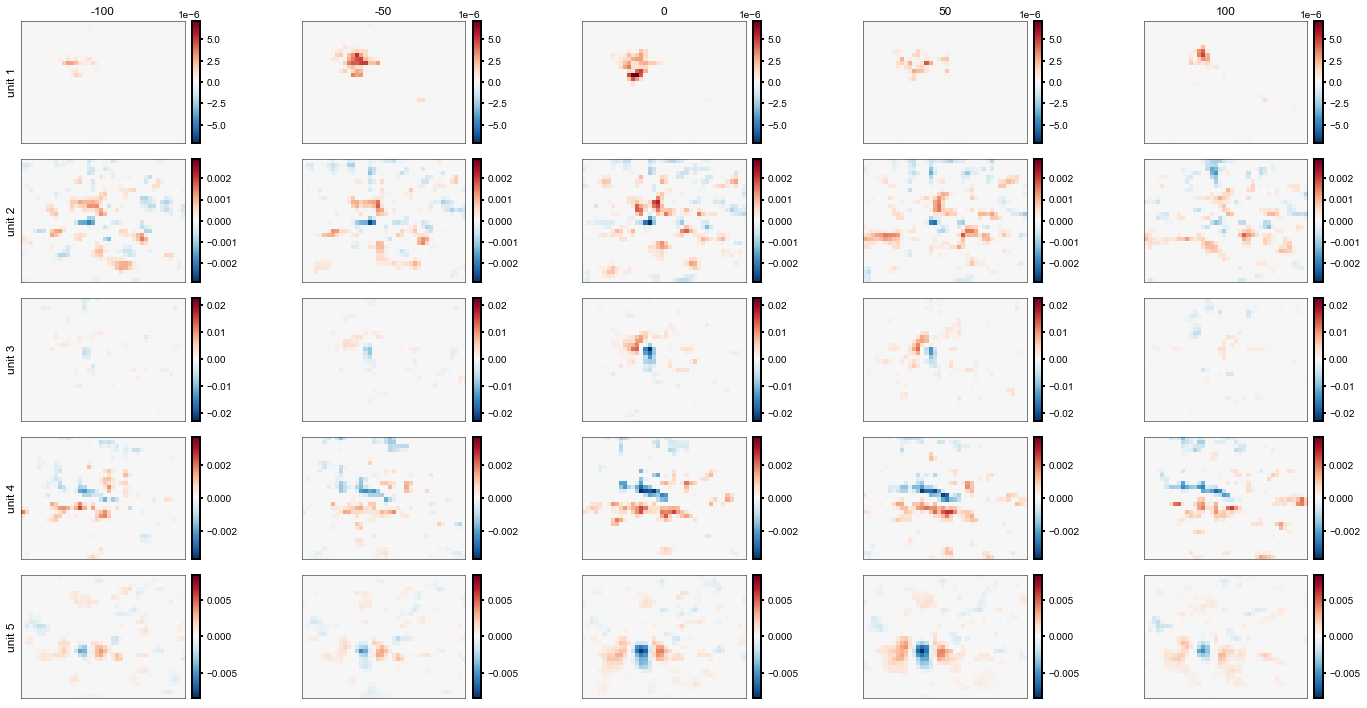

In [5]:
fontsize=12
lag_ls = [-100,-50,0,50,100] # ['Normal','Square']
lag_list = [-2,1,0,1,2]
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [1,4,22,42,101] #np.arange(20) # np.arange(All_data[date_ani2[da]]['vis_rf_all'].shape[0]) #

fig1,axs1 = plt.subplots(len(cells),len(lag_list),figsize=(20,2*len(cells)))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_all'][cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][cell,m],'RdBu_r',vmin=-crange,vmax=crange)
        add_colorbar(im)
        axs1[0,m].set_title('{}'.format(lag_ls[m]),fontsize=fontsize)
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

# cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
# cbar2.set_ticks([-crange, crange])
# cbar2.set_ticklabels(['dark', 'light'])
# cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
# cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
# fig1.savefig(paper_fig_dir/'example_RFs.png')


Text(0.5, 1.0, '0.329')

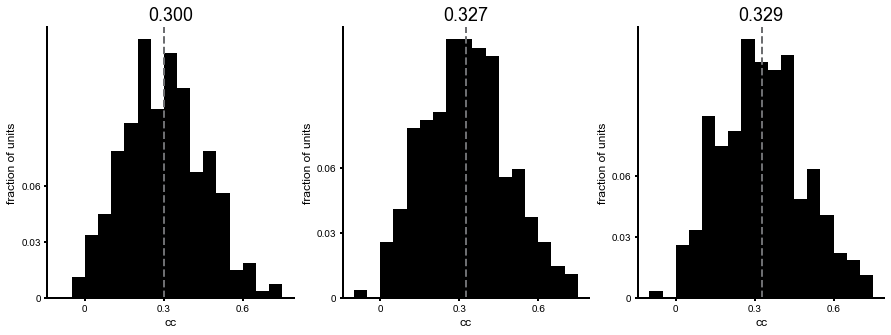

In [6]:
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
# vals_Vis[vals_Vis<0] = np.nan
# vals_Add[vals_Add<0] = np.nan
# vals_Mul[vals_Mul<0] = np.nan

fig, axs = plt.subplots(1,3, figsize=(15,5))
hbins = .05
lim0 = -.1
lim1 = .8
dlim = .2
xlab = 'cc'

ax = axs[0]
count,edges = np.histogram(vals_Vis,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Vis),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Vis),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Vis)))

ax = axs[1]
count,edges = np.histogram(vals_Add,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Add),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Add),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Add)))

ax = axs[2]
count,edges = np.histogram(vals_Mul,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Mul),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Mul)))
# fig.savefig(paper_fig_dir/'cc_hist.png')


0.6325838189539539

(0.24000025317137663, 0.3321105380967906, 0.3207981966328047)

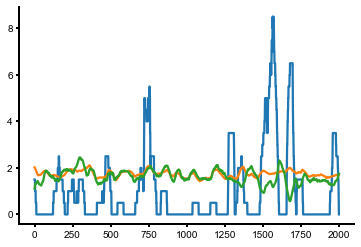

In [7]:
celln = 52
t = 0
dt = 2000
plt.plot(All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln])
plt.plot(All_data[date_ani2[da]]['vis_pred_smooth'][t:t+dt,celln])

plt.plot(All_data[date_ani2[da]]['mul_pred_smooth'][t:t+dt,celln])
vals_Vis[celln],vals_Add[celln],vals_Mul[celln]



In [8]:
malph, mlam, cellnum = np.where(All_data[date_ani2[da]]['vis_loss_regcv'] == np.nanmin(All_data[date_ani2[da]]['vis_loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]
mlam

array([13, 19, 19, 14, 12, 19, 17, 16, 16, 13, 11, 11, 11, 11, 10, 10, 13,
       19, 14, 14, 19, 19,  8, 15, 16, 19, 13, 19,  9, 15, 19, 19, 15, 19,
       13, 19, 14, 19, 12, 19, 11, 11, 10, 10, 13, 15, 19, 13, 19, 16, 19,
       19, 19, 13, 19, 19, 13, 19, 19, 14, 12, 13, 13, 15, 14, 16, 12, 13,
       19, 12, 11, 13, 14, 15, 12, 15, 12, 13, 19, 16, 16, 19,  8, 19, 18,
       19, 12, 14, 13, 16, 19, 19, 15, 19, 19, 19, 14, 19, 13, 12, 11, 11,
       13, 10, 19, 12, 13, 19])

In [10]:
np.sum(np.isnan(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,:]),axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
a=0; l=17
# params['alphas'] = np.array([0.000001])
params['alpha_l'] = np.hstack((0, np.logspace(2, 9, 20,base=10)))
# params['lambdas'] = np.hstack((0, np.logspace(-2, 3, 20)))
params['alpha_l'][l],#params['lambdas'] [l]

(78475997.03514607,)

In [15]:
np.hstack((0, np.logspace(2, 8, 20,base=10)))[-1]

100000000.0

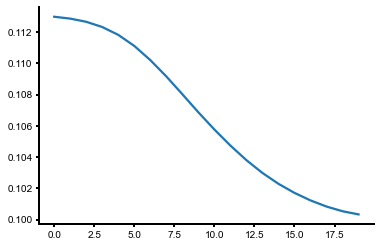

In [11]:
plt.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,25].T)

In [17]:
np.nanmean(vals_Mul)

0.29974393645351993

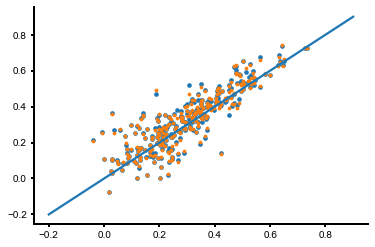

In [12]:
plt.scatter(vals_Vis,vals_Mul,10)
plt.scatter(vals_Vis,vals_Add,5)
plt.plot(np.arange(-.2,1,.1),np.arange(-.2,1,.1))

(array([ 1.,  2.,  4.,  4., 21., 18., 15., 20., 30., 19., 30., 29., 19.,
        13., 13.,  8.,  6.,  8.,  2.,  3.]),
 array([-0.0777759 , -0.03672739,  0.00432112,  0.04536963,  0.08641814,
         0.12746665,  0.16851516,  0.20956367,  0.25061218,  0.29166068,
         0.33270919,  0.3737577 ,  0.41480621,  0.45585472,  0.49690323,
         0.53795174,  0.57900025,  0.62004876,  0.66109726,  0.70214577,
         0.74319428]),
 <BarContainer object of 20 artists>)

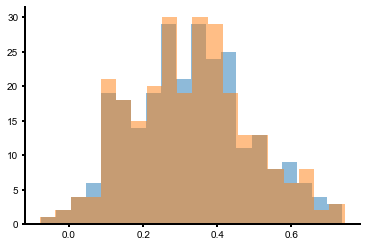

In [13]:
plt.hist(vals_Mul,bins=20,alpha=.5)
plt.hist(vals_Add,bins=20,alpha=.5)


In [23]:
All_data[date_ani2[da]].keys()

dict_keys(['actual_meanfr', 'actual_smooth', 'actual_HF_smooth', 'pos_pred_smooth', 'pos_vloss_all', 'pos_vloss_trace', 'pos_moveW', 'pos_cc_test', 'pos_r2_test', 'vis_pred_smooth', 'vis_vloss_all', 'vis_vloss_trace', 'vis_loss_regcv', 'vis_rf_up', 'vis_rf_all', 'vis_cc_test', 'vis_r2_test', 'add_pred_smooth', 'add_vloss_all', 'add_vloss_trace', 'add_moveW', 'add_cc_test', 'add_r2_test', 'mul_pred_smooth', 'mul_vloss_all', 'mul_vloss_trace', 'mul_moveW', 'mul_cc_test', 'mul_r2_test', 'HF_pred_smooth', 'HF_vloss_all', 'HF_vloss_trace', 'HF_loss_regcv', 'HF_rf_up', 'HF_rf_all', 'HF_cc_test', 'HF_r2_test', 'HF_meanfr', 'HF_FMHF_r2'])

Text(0.5, 0.98, 'vis_cc: 0.386, add_cc: 0.444, mul_cc: 0.431')

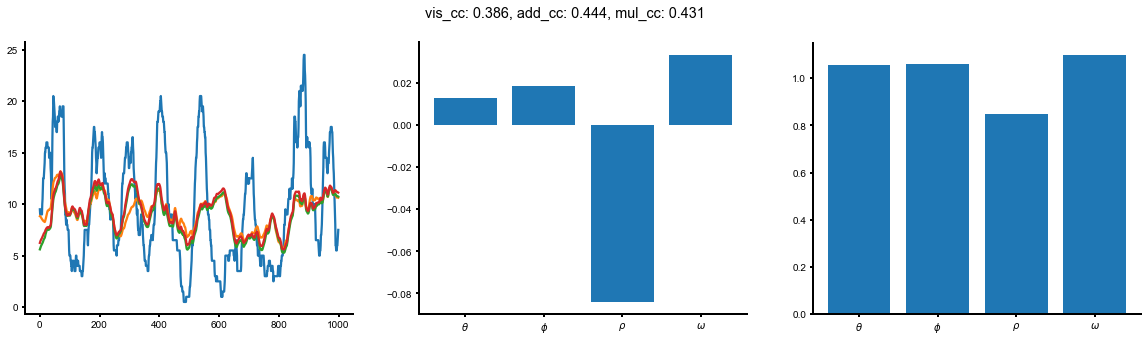

In [16]:
CC_Vis = GLM_Data['cc_test'].copy()
t = 0
dt = 1000
celln = 101 # np.nanargmax(GLM_Data['cc_test'])
fig, axs = plt.subplots(1,3,figsize=(20,5))
ax = axs[0]
ax.plot(All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln])
ax.plot(All_data[date_ani2[da]]['vis_pred_smooth'][t:t+dt,celln])
ax.plot(All_data[date_ani2[da]]['add_pred_smooth'][t:t+dt,celln])
ax.plot(All_data[date_ani2[da]]['mul_pred_smooth'][t:t+dt,celln])


ax = axs[1]
ax.bar(titles,All_data[date_ani2[da]]['add_moveW'][celln]+All_data[date_ani2[da]]['add_moveBias'][celln])

ax = axs[2]
ax.bar(titles,All_data[date_ani2[da]]['mul_moveW'][celln]+All_data[date_ani2[da]]['mul_moveBias'][celln])

plt.suptitle('vis_cc: {:.03f}, add_cc: {:.03f}, mul_cc: {:.03f}'.format(All_data[date_ani2[da]]['vis_cc_test'][celln],All_data[date_ani2[da]]['add_cc_test'][celln],All_data[date_ani2[da]]['mul_cc_test'][celln]))



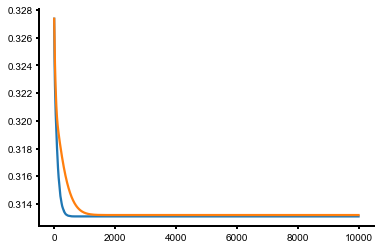

In [17]:
celln = 42
plt.plot(All_data[date_ani2[da]]['add_vloss_all'][celln].T)
plt.plot(All_data[date_ani2[da]]['mul_vloss_all'][celln].T)


# Train Single

In [3]:
args = arg_parser(jupyter=True)
MovModel = 3
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['train_shifter']   = False
args['NoL1']            = True
args['NoL2']            = True
args['reg_lap']         = True
args['complex']         = False
args['do_shuffle']      = False
args['Nepochs'] = 10000


params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, comples: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))

Done Loading Unaligned data
Tot_units: (128,)
Model: 3, LinMix: False, move_features: 4, Ncells: 108, train_shifter: False, NoL1: True, NoL2: True, reg_lap: True, comples: False


In [4]:
a=0; l=0; b=11
# params['alphas'] = np.array([0.001])
params['alphas_m'] = np.array(params['nalph']*[.0001])
# params['alpha_l'] = np.hstack((0, np.logspace(2, 8, 20,base=10)))
# params['lambdas'] = np.hstack((0, np.logspace(-2, 3, 20)))
# params['alpha_l'][b]#,params['lambdas'][l]

In [5]:
l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, params['MovModel'], device, l, a, params, NepochVis=10000)
vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=None)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
GLM_Data = {}
for name, p in l1.named_parameters():
    GLM_Data[name] = p.clone().cpu().detach().numpy()
pred = l1(xte, xtem, shift_in_te)
GLM_Data['loss_regcv'] = np.mean(vloss_trace.T[:,-10:],axis=-1) # l1.loss(pred, yte).cpu().detach().numpy()
GLM_Data['pred_cv'] = pred.detach().cpu().numpy().squeeze().T
out = l1(xtr, xtrm, shift_in_tr)
GLM_Data['out_cv'] = out.detach().cpu().numpy().squeeze().T
test_nsp = yte.cpu().detach().numpy()
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp)[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'])[:,params['bin_length']:-params['bin_length']].T
GLM_Data['r2_test'] = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
GLM_Data['cc_test'] = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1]) for celln in range(params['Ncells'])])

In [7]:
RF = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
GLM_Data['cc_test']

array([ 0.33412916, -0.01673948,  0.27313685,  0.26458442,  0.46855781,
       -0.10566547,  0.24602812,  0.38681658,  0.35118887,  0.47308307,
        0.57610693,  0.44232951,  0.40030621,  0.52593493,  0.51718161,
        0.73081005,  0.32092002,  0.06431502,  0.55305757,  0.39248532,
        0.1894457 ,  0.21131103,  0.49963076,  0.34239019,  0.08247633,
        0.38524987,  0.51259848,  0.29573588,  0.54645094,  0.53662832,
        0.03583223, -0.01453204,  0.42551382,  0.01628489,  0.14232911,
        0.32242899,  0.25617525,  0.02401677,  0.45546104,  0.15364674,
        0.6199305 ,  0.56151297,  0.59113522,  0.46899241,  0.41341953,
        0.40837162,  0.19898462,  0.55802677,  0.29457425,  0.50924583,
        0.26376415,  0.27853574,  0.39950134,  0.31206955,  0.11292208,
        0.14096867,  0.58274029,  0.15706136,  0.12823855,  0.3579171 ,
        0.14614006,  0.26304145,  0.27223085,  0.5225427 ,  0.31791782,
        0.45414577,  0.33357615,  0.21442021,  0.04527383,  0.57

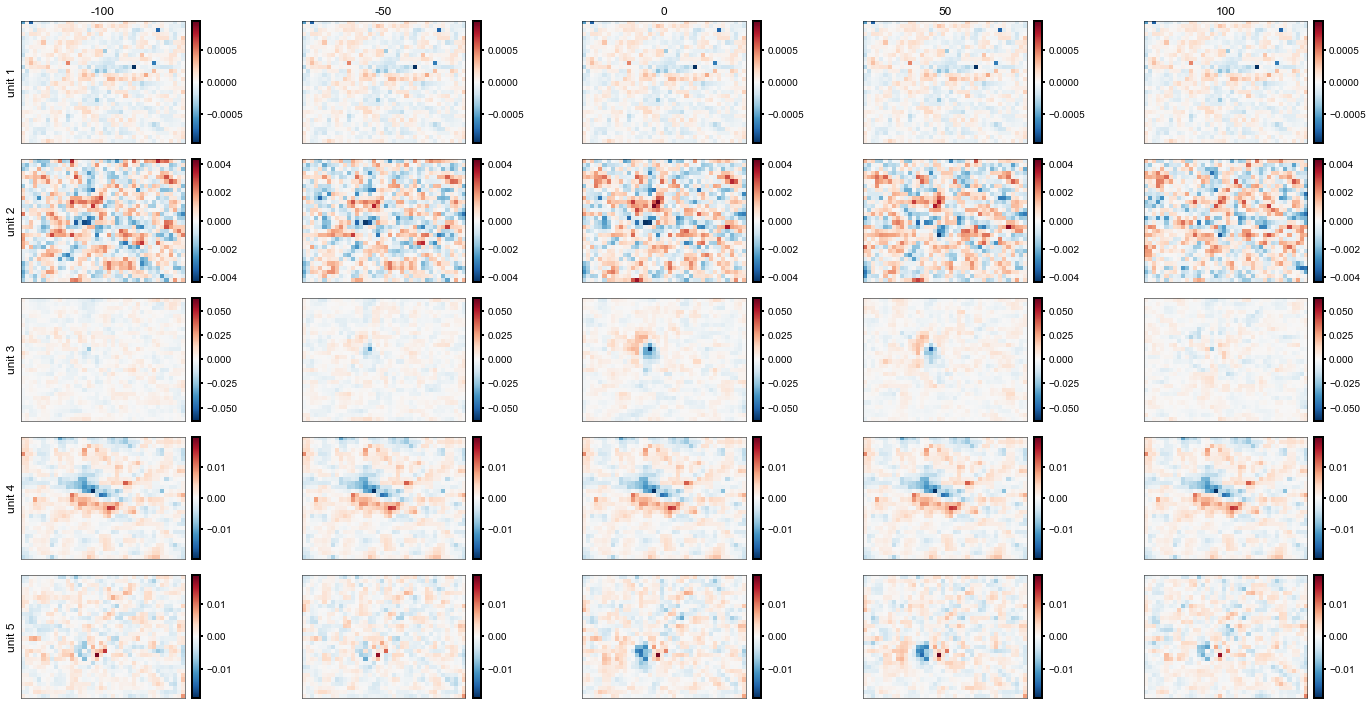

In [8]:
fontsize=12
lag_ls = [-100,-50,0,50,100] # ['Normal','Square']
lag_list = params['lag_list']
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [1,4,22,42,101] #np.arange(20) # np.arange(All_data[date_ani2[da]]['vis_rf_all'].shape[0]) #

fig1,axs1 = plt.subplots(len(cells),len(lag_list),figsize=(20,2*len(cells)))
axs1 = axs1.reshape(len(cells),len(lag_list))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(RF[cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(RF[cell,m],'RdBu_r',vmin=-crange,vmax=crange)
        add_colorbar(im)
        axs1[0,m].set_title('{}'.format(lag_ls[m]),fontsize=fontsize)
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

# cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
# cbar2.set_ticks([-crange, crange])
# cbar2.set_ticklabels(['dark', 'light'])
# cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
# cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
# fig1.savefig(paper_fig_dir/'example_RFs.png')


Text(0.5, 0.98, 'cc: 0.408')

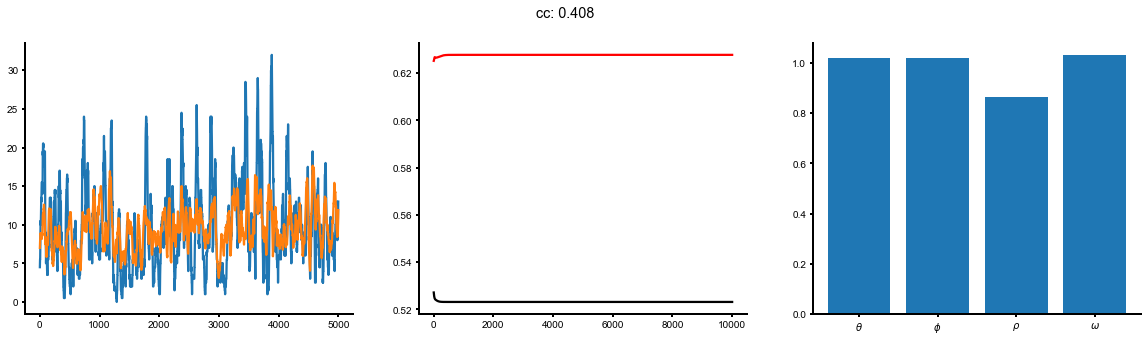

In [11]:
CC_Vis = GLM_Data['cc_test'].copy()
t = 0
dt = 5000
celln = 101 # np.nanargmax(GLM_Data['cc_test'])
fig, axs = plt.subplots(1,3,figsize=(20,5))
ax = axs[0]
ax.plot(sp_smooth[t:t+dt,celln])
ax.plot(pred_smooth[t:t+dt,celln])

ax = axs[1]
ax.plot(vloss_trace[:,celln],'r')
ax.plot(tloss_trace[:,celln],'k')

if (MovModel==2) | (MovModel==3):
    ax = axs[2]
    ax.bar(titles,GLM_Data['posNN.Layer0.weight'][celln]+GLM_Data['posNN.Layer0.bias'][celln])

plt.suptitle('cc: {:.03f}'.format(GLM_Data['cc_test'][celln]))




array([ 0.01935343,  0.01804761, -0.13868093,  0.02762285], dtype=float32)

In [72]:
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp)[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T


In [19]:
malph, mlam, cellnum = np.where(GLM_Data['loss_regcv'] == np.nanmin(GLM_Data['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

In [20]:
mlam

array([16, 15, 20, 10, 16, 16, 17,  9, 16,  8,  8, 14,  8,  8, 15,  6, 15,
       17, 13, 13, 12, 15, 14, 17, 14, 12, 15, 14,  7, 14, 15, 15,  9, 16,
       13, 13, 17, 16, 16, 15, 16,  8, 13,  8, 16, 14, 15, 16, 15, 12, 13,
       12, 13, 14, 15, 13,  8, 16, 15, 13, 16, 13, 14, 14, 16, 11, 16, 14,
       15,  9, 16, 15,  9, 15, 17, 13,  8, 13, 15, 14, 16, 15, 14, 13, 15,
       15, 17, 15,  7, 15, 15, 15, 13, 15, 15, 14, 16, 14, 16,  8, 15, 15,
       15, 15, 13, 15,  9, 15])

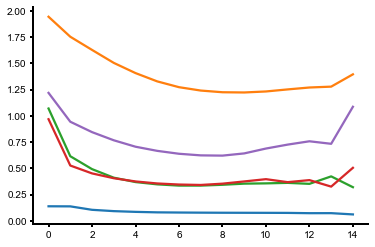

In [22]:
plt.plot(GLM_Data['loss_regcv'][0,:15,cells].T)

0.4001446993727774

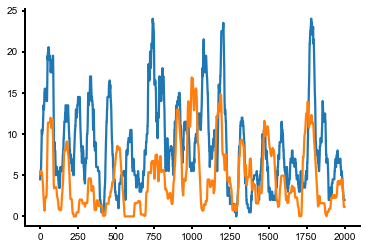

In [24]:
CC_Vis = GLM_Data['cc_test'].copy()
t = 0
dt = 2000
celln = 101# np.nanargmax(GLM_Data['cc_test'])
plt.plot(sp_smooth[t:t+dt,celln])
plt.plot(pred_smooth[t:t+dt,celln])
GLM_Data['cc_test'][celln]

In [ ]:
CC_Add = GLM_Data['cc_test'].copy()
celln = 101# np.nanargmax(GLM_Data['cc_test'])
plt.plot(actual_smooth[1000:2000,celln])
plt.plot(pred_smooth[1000:2000,celln])
GLM_Data['cc_test'][celln]

In [ ]:
CC_Mul = GLM_Data['cc_test'].copy()
celln = 101# np.nanargmax(GLM_Data['cc_test'])
plt.plot(actual_smooth[1000:2000,celln])
plt.plot(pred_smooth[1000:2000,celln])
GLM_Data['cc_test'][celln]

NameError: name 'CC_Add' is not defined

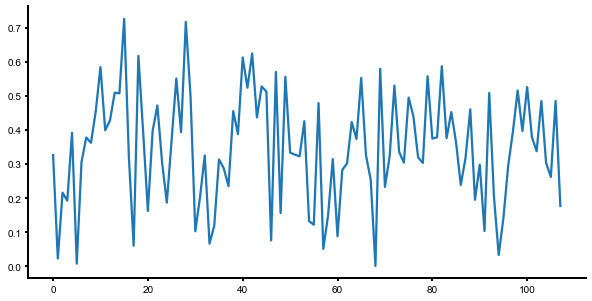

In [34]:
plt.figure(figsize=(10,5))
plt.plot(CC_Vis)
plt.plot(CC_Add)
plt.plot(CC_Mul)

In [ ]:
fontsize=12
lag_ls = [-100,-50,0,50,100] # ['Normal','Square']
lag_list = [-2,1,0,1,2]
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [1,4,22,42,101] #np.arange(20) # np.arange(All_data[date_ani2[da]]['vis_rf_all'].shape[0]) #

fig1,axs1 = plt.subplots(len(cells),len(lag_list),figsize=(20,2*len(cells)))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_all'][cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][cell,m],'RdBu_r',vmin=-crange,vmax=crange)
        add_colorbar(im)
        axs1[0,m].set_title('{}'.format(lag_ls[m]),fontsize=fontsize)
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

# cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
# cbar2.set_ticks([-crange, crange])
# cbar2.set_ticklabels(['dark', 'light'])
# cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
# cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
# fig1.savefig(paper_fig_dir/'example_RFs.png')


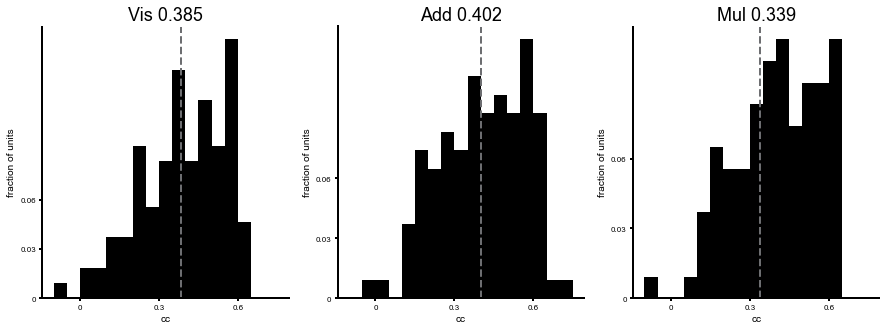

In [36]:
vals_Vis = CC_Vis
vals_Add = CC_Add
vals_Mul = CC_Mul


fig, axs = plt.subplots(1,3, figsize=(15,5))
hbins = .05
lim0 = -.1
lim1 = .8
dlim = .2
xlab = 'cc'

ax = axs[0]
count,edges = np.histogram(vals_Vis,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Vis),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Vis),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('Vis {:.03f}'.format(np.nanmean(vals_Vis)))

ax = axs[1]
count,edges = np.histogram(vals_Add,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Add),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Add),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('Add {:.03f}'.format(np.nanmean(vals_Add)))

ax = axs[2]
count,edges = np.histogram(vals_Mul,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Mul),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('Mul {:.03f}'.format(np.nanmean(vals_Mul)))
# fig.savefig(paper_fig_dir/'cc_hist.png')


In [78]:
D

array([[ 2., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  3., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  3., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
# Initialize mult weights to 1 and add weights to very close to 0  

In [18]:
b = np.diag(-1*np.ones((input_size-1)),1)
c = np.diag(-1*np.ones((input_size-1)),-1)
aa = 2*np.ones(input_size)
aa[[0,-1]] = 1
aa = np.diag(aa)
lap_M = torch.from_numpy(((b + c + aa)*params['model_dt']).astype(np.float32))


In [14]:
l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, params['MovModel'], device, 1, 0, params, lap_M=lap_M, NepochVis=10000)


# Load Complex Data

In [3]:
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'RevisionFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
move_clrs = ['blue','orange','green','red'] #["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
q_clrs = ["#f72585","#7209b7","#3f37c9","#4cc9f0"] # Magenta to Blue
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"] #["#003d36", "#a38d00", "#ff3b05", "#70a0ff"]#["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
# mod_clrs = ["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
fontsize=10
mod_titles = ['pos','vis','add','mul','HF']

import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "Arial",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'

                    })

In [9]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all = ['070921/J553RT','101521/J559NC']#,'102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move']       = True
    args['date_ani']        = date_ani
    args['train_shifter']   = False
    args['NoL1']            = False
    args['NoL2']            = False
    args['reg_lap']         = False
    args['complex']         = True
    args['do_shuffle']      = False
    args['Nepochs']         = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('RevisionSims' in path.as_posix()) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    model_move_FM.append(model_move)
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)
model_move_FM = np.concatenate(model_move_FM,axis=0)
model_move_HF = np.concatenate(model_move_HF,axis=0)
ModelList_all

Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [12]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        ModelRun = ModelRun+1
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            if params['complex']:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
            else:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun != 4):
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done Loading Unaligned data
Tot_units: (128,)


In [6]:

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


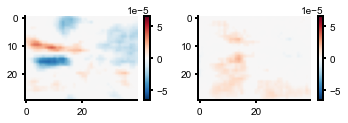

In [18]:
celln = 62
fig, axs = plt.subplots(1,2,figsize=(5,10))
crange =  np.max(np.abs(All_data[date_ani2[da]]['vis_rf_all'][celln]))
ax = axs[0]
im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][celln,3],'RdBu_r',vmin=-crange,vmax=crange)
add_colorbar(im)
ax = axs[1]
im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][celln,5],'RdBu_r',vmin=-crange,vmax=crange)
add_colorbar(im)
plt.tight_layout()

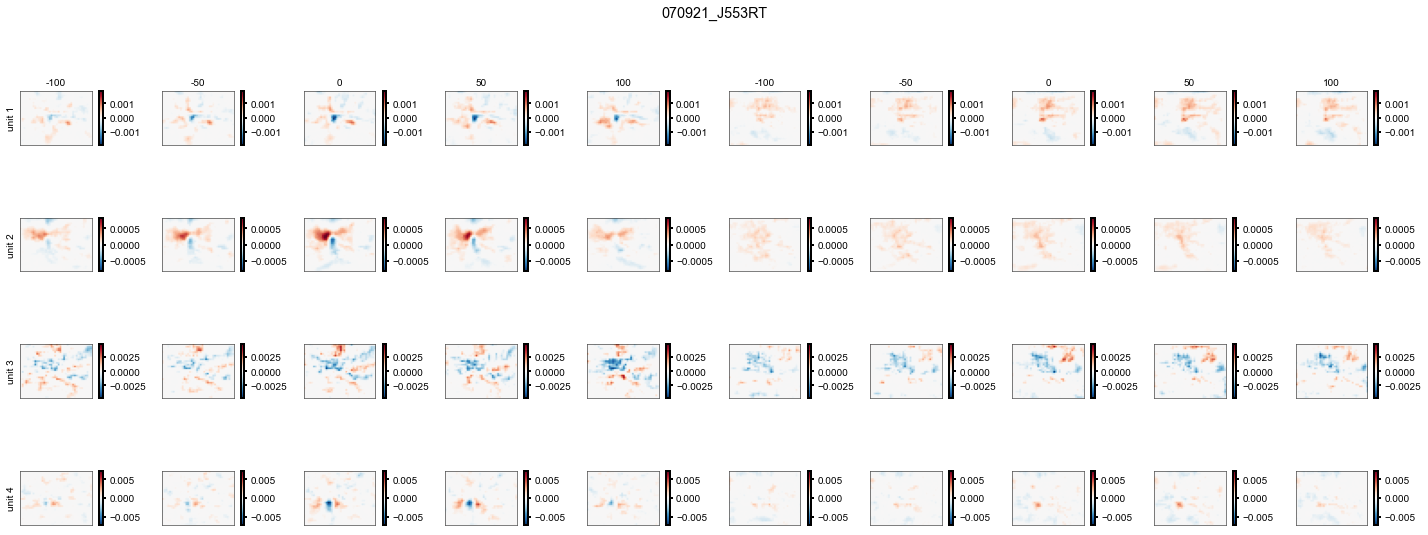

In [30]:
pdf_name = paper_fig_dir/ ('Complex_Cell_Summary.pdf')

# pdf = PdfPages(pdf_name)

lag_ls = [-100,-50,0,50,100,-100,-50,0,50,100] # ['Normal','Square']
lag_list = [-2,1,0,1,2,-2,1,0,1,2]
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [0,22,28,101] #np.arange(20) # np.arange(All_data[date_ani2[da]]['vis_rf_all'].shape[0]) #

fig1,axs1 = plt.subplots(len(cells),len(lag_list),figsize=(20,2*len(cells)))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_all'][cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_all'][cell,m],'RdBu_r',vmin=-crange,vmax=crange)
        add_colorbar(im)
        axs1[0,m].set_title('{}'.format(lag_ls[m]),fontsize=fontsize)
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

# cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
# cbar2.set_ticks([-crange, crange])
# cbar2.set_ticklabels(['dark', 'light'])
# cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
# cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(date_ani2[da],y=1)
plt.tight_layout()
# pdf.savefig()
# plt.close()

# pdf.close()

In [10]:
All_data[date_ani2[da]]['vis_rf_all'].shape

(108, 10, 30, 40)

Text(0.5, 1.0, '0.436')

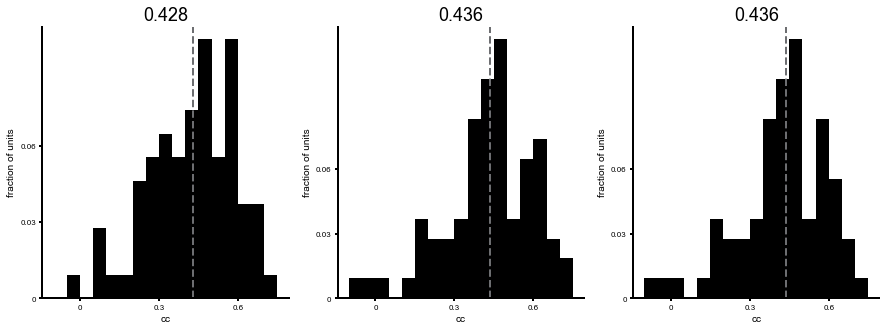

In [20]:
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
# vals_Vis[vals_Vis<0] = np.nan
# vals_Add[vals_Add<0] = np.nan
# vals_Mul[vals_Mul<0] = np.nan

fig, axs = plt.subplots(1,3, figsize=(15,5))
hbins = .05
lim0 = -.1
lim1 = .8
dlim = .2
xlab = 'cc'

ax = axs[0]
count,edges = np.histogram(vals_Vis,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Vis),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Vis),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Vis)))

ax = axs[1]
count,edges = np.histogram(vals_Add,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Add),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Add),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Add)))

ax = axs[2]
count,edges = np.histogram(vals_Mul,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.set_xticks([0,.3,.6])
ax.set_xticklabels([0,.3,.6],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(vals_Mul),lw=2, c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)
ax.set_title('{:.03f}'.format(np.nanmean(vals_Mul)))
# fig.savefig(paper_fig_dir/'cc_hist.png')


(0.7725466822187811, 0.7712669655011943, 0.7681498223217474)

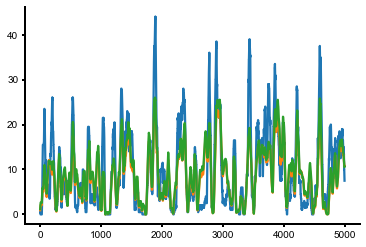

In [28]:
celln = np.nanargmax(vals_Vis)
t = 3000
dt = 5000
plt.plot(All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln])
plt.plot(All_data[date_ani2[da]]['vis_pred_smooth'][t:t+dt,celln])

plt.plot(All_data[date_ani2[da]]['mul_pred_smooth'][t:t+dt,celln])
vals_Vis[celln],vals_Add[celln],vals_Mul[celln]



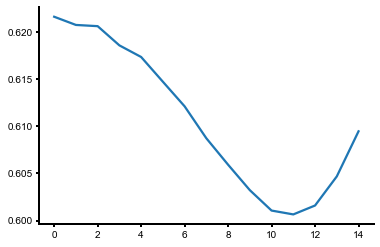

In [23]:
plt.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:15,101])

In [16]:
np.nanmean(vals_Mul)

0.3341576743970438

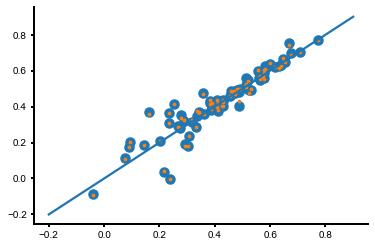

In [24]:
plt.scatter(vals_Vis,vals_Mul)
plt.scatter(vals_Vis,vals_Add,5)
plt.plot(np.arange(-.2,1,.1),np.arange(-.2,1,.1))

(array([ 1.,  0.,  1.,  1.,  1.,  0.,  6.,  1.,  3.,  4.,  7.,  8.,  7.,
        12.,  4.,  6.,  6.,  4.,  2.,  2.]),
 array([-0.0900242 , -0.04695965, -0.00389509,  0.03916947,  0.08223403,
         0.12529859,  0.16836315,  0.21142771,  0.25449226,  0.29755682,
         0.34062138,  0.38368594,  0.4267505 ,  0.46981506,  0.51287961,
         0.55594417,  0.59900873,  0.64207329,  0.68513785,  0.72820241,
         0.77126697]),
 <BarContainer object of 20 artists>)

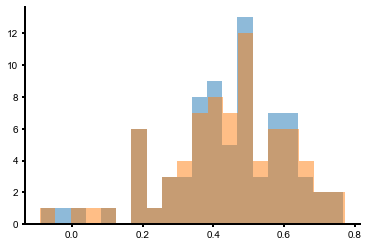

In [25]:
plt.hist(vals_Mul,bins=20,alpha=.5)
plt.hist(vals_Add,bins=20,alpha=.5)


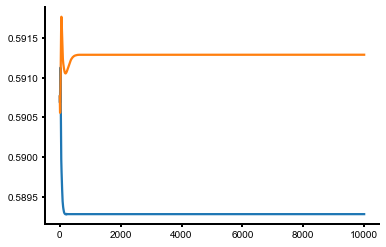

In [26]:
plt.plot(All_data[date_ani2[da]]['add_vloss_all'][101])
plt.plot(All_data[date_ani2[da]]['mul_vloss_all'][101])

# Full Figure CC Version

In [18]:
da = 1
args['free_move']=True
args['do_shuffle']=False
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (67,)


/tmp/ipykernel_1044277/1408568754.py:181: RuntimeWarning: All-NaN slice encountered
  vals_AM = np.nanmax(np.stack((vals_Add,vals_Mul)),axis=0)


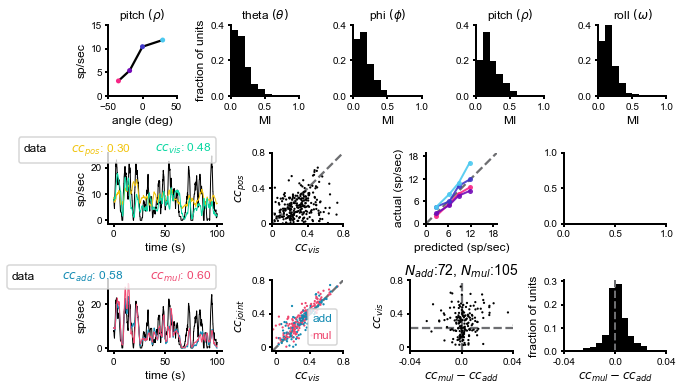

In [19]:
###### Fig 4 with CC

titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
celln = 52#
modN = 1
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs0a = np.array([fig.add_subplot(gs00[0,m]) for m in range(5)])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

modeln = 2
ax = axs0a[0]
metric = move_data[params['bin_length']:-params['bin_length'],modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

edge_mids = np.quantile(metric,spk_percentile2)#
# ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
ax.set_xlim(-xlim_range,xlim_range)
ax.set_ylim(0,15)
ax.set_xlabel('angle (deg)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.set_title(titles[modeln],fontsize=fontsize)

########## Fig 4B ########## 
##### Modulation Index Histograms #####
dwidth = .1
for modeln in np.arange(0,len(titles)):
    ax = axs0a[modeln+1]
    count,edges = np.histogram(tuning_sig_all[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(tuning_sig_all[:,modeln]),color='k',width=dwidth,alpha=1)
    ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
    ax.set_xlabel('MI', fontsize=fontsize)
    # ax.set_ylabel('fraction of units', fontsize=fontsize)
    ax.set_xlim(0,1)
    ax.set_yticks(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_yticklabels(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_ylim(0,.4)
axs0a[1].set_ylabel('fraction of units', fontsize=fontsize)

########## Fig 4C/G ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[1:,:1],wspace=.05,hspace=.8)
axs1a = np.array([fig.add_subplot(gs01[0,0])])
axs2a = np.array([fig.add_subplot(gs01[1,0])])

cmap = mpl.colors.ListedColormap(q_clrs)

celln = 52#106
da = 1
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
dt = int(100/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs1a[0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles[:-1]))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(0,2):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=1,
            label=r'$cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln]),zorder=zorder[modN])
legend1 = ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
# legend1.texts[1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)


##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2a[0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln] for modN in range(len(mod_titles[:-1]))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=1,label='data',zorder=0)
for modN in range(2,len(mod_titles)-1):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=1,
            label=r' $cc_{{{}}}$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_cc_test'][celln]),zorder=zorder[modN])
ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)



gs02 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs0[1:,1:],wspace=.5,hspace=.8)
axs3a = np.array([fig.add_subplot(gs02[n,m]) for n in range(2) for m in range(3)]).reshape(2,3)

########## Fig 4D ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])


tuning_idx = np.where(tuning_sig_all2)[0]
lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
##### Vis vs Mot #####
ax = axs3a[0,0]
im=ax.scatter(vals_Vis,vals_Mot,c='k',s=5,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{pos}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(0,.8)
ax.set_xlim(0,.8)



########## Fig 4E ########## 

ax = axs3a[0,1]
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts 
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    ax.plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=2,ms=10,alpha=.9,zorder=2,markeredgewidth=0)
    ax.set_xlabel('predicted (sp/sec)',fontsize=fontsize)
    ax.set_ylabel('actual (sp/sec)',fontsize=fontsize)

lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
lims = (-.05, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),c='#6D6E71',ls='--',zorder=0)
# ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
ax.set_xticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_yticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_xticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.set_yticklabels(np.arange(0,lims[1],int(lims[1]/3),dtype=int))
ax.axis('square')
ax.set(xlim=lims, ylim=lims)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)


########## Fig 4H ########## 

##### Vis vs Add/Mul #####
cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
vals_AM = np.nanmax(np.stack((vals_Add,vals_Mul)),axis=0)
AvM = vals_Add<vals_Mul
AvM_thresh = (~np.isnan(vals_Vis)) & (~np.isnan(vals_AM))
ax = axs3a[1,0]
scatter=ax.scatter(vals_Vis[AvM_thresh],vals_AM[AvM_thresh],s=5,c=AvM[AvM_thresh],cmap=cmap_mod,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{joint}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(-.05, .8)
ax.set_xlim(-.05, .8)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),fontsize=fontsize,markerscale=0, handlelength=0, handletextpad=0,loc="lower right")
legend1.get_texts()[0].set_text('add')
legend1.get_texts()[0].set_color(mod_clrs[2])
legend1.get_texts()[1].set_text('mul')
legend1.get_texts()[1].set_color(mod_clrs[3])

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]


##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[1,1]
im = ax.scatter(diff[th],increase[th],s=5,c='k',edgecolors='none')
# im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_title(r'$N_{{add}}$:{}, $N_{{mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize+2)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.04,.04)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0)


##### Hist of Add-Mul #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_cc_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_cc_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['add_cc_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_cc_test'] for da in range(len(dates_all))])
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) & (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]
ax=axs3a[1,2]
hbins=.005
count,edges = np.histogram(vals_Mul-vals_Add,bins=np.arange(-.05,.05,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='k',width=hbins, alpha=1)
ax.axvline(x=0,c='#6D6E71',ls='--',lw=2)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_xlim([-.04, .04])
ax.set_yticks([0,.1,.2,.3])

plt.show()
gs0.tight_layout(fig)

# fig.savefig(paper_fig_dir/'Fig4_draft_V4_Cell52_101521_cc.pdf', facecolor='white', transparent=True, bbox_inches='tight')


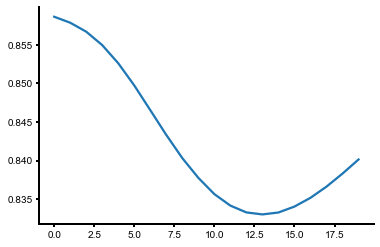

In [20]:
# plt.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,0])
# plt.plot(np.mean(All_data[date_ani2[da]]['vis_loss_regcv'][0],axis=-1))

(-0.09250000000000001,
 0.9693258066914214,
 -0.2135609972963567,
 0.8482648093950648)

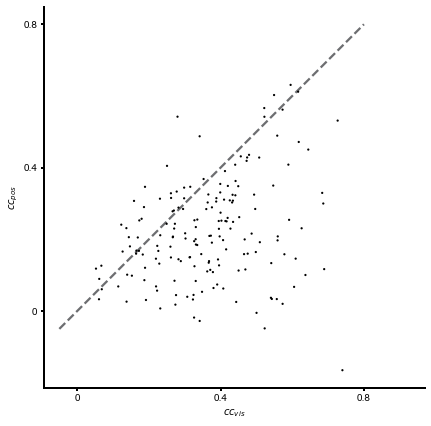

In [16]:
tuning_idx = np.where(tuning_sig_all2)[0]
lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
##### Vis vs Mot #####
fig, axs = plt.subplots(figsize=(7,7))
ax = axs
im=ax.scatter(vals_Vis,vals_Mot,c='k',s=5,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{pos}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
# ax.set_ylim(0,.8)
# ax.set_xlim(0,.8)


# Shifter Testing

In [76]:
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
params['save_dir']

In [18]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'  # 'fm1' #
    
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
args['train_shifter']=True
args['shifter_5050'] = False
args['NoL1'] = True
args['NoL2'] = True
args['complex'] = False
args['reg_lap'] = True
args['do_norm']=True
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

params = get_modeltype(params)
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(params['model_type'],int(params['model_dt']*1000), 1, 5000,Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))


##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)
params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))
GLM_Shifter = ioh5.load(ModelList[0])

Done Loading Unaligned data
Tot_units: (128,)
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: True


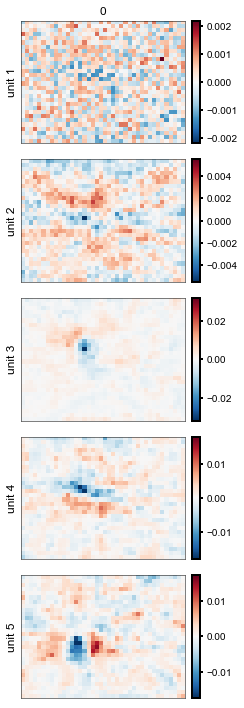

In [51]:
GLM_Shifter.keys()
RF = GLM_Shifter['Cell_NN.0.weight'].reshape((GLM_Shifter['Cell_NN.0.weight'].shape[0],1,)+params['nks'])
fontsize=12
lag_ls = [0] # ['Normal','Square']
lag_list = [0]
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [1,4,22,42,101] #np.arange(20) # np.arange(All_data[date_ani2[da]]['vis_rf_all'].shape[0]) #

fig1,axs1 = plt.subplots(len(cells),len(lag_list),figsize=(20,2*len(cells)))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(RF[cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n]
        im = ax.imshow(RF[cell,m],'RdBu_r',vmin=-crange,vmax=crange)
        add_colorbar(im)
        axs1[0].set_title('{}'.format(lag_ls[m]),fontsize=fontsize)
    axs1[n].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

# cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
# cbar2.set_ticks([-crange, crange])
# cbar2.set_ticklabels(['dark', 'light'])
# cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
# cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
# fig1.savefig(paper_fig_dir/'example_RFs.png')



In [32]:
model_type = '_'.join(params['model_type'].split('_')[2:])
model_name = '*{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
model_file = list(save_model_fm.glob(model_name))[0]

In [33]:
##### Load single shifter network and shift videos #####
best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm = params['save_model_shift']

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_type = '_'.join(params['model_type'].split('_')[2:])
model_name = '*{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
model_file = list(save_model_fm.glob(model_name))[0]

# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_file)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

ds = 4/params['downsamp_vid']
shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
shift_vid_file = params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1)
# ioh5.save(shift_vid_file,model_vid_sm_shift2)
# print(shift_vid_file)

17


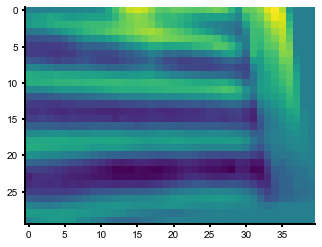

In [34]:
plt.imshow(model_vid_sm_shift[0])

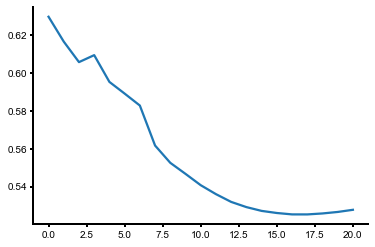

In [35]:
plt.plot(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))

In [36]:
params['save_dir_fm']

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data2/070921/J553RT/fm1')

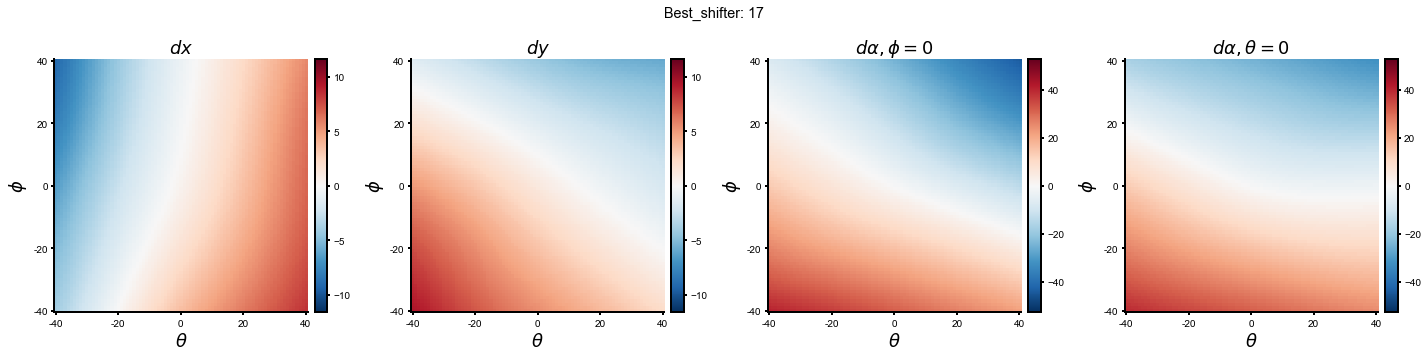

In [37]:
# l1.cpu()
FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)


fig, ax = plt.subplots(1,4,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(4):
    im1=ax[n].imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(ticklabels)
    ax[n].set_yticks(ticks)
    ax[n].set_yticklabels(ticklabels)
    ax[n].set_xlabel(r'$\theta$')
    ax[n].set_ylabel(r'$\phi$')
    ax[n].set_title(shift_titles[n])

plt.suptitle('Best_shifter: {}'.format(best_shifter))
plt.tight_layout()


In [51]:
shift_mat1 = shift_matshow.copy()

In [44]:
shift_mat0 = shift_matshow.copy()

# Shifter 50/50 

In [23]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'  # 'fm1' #
    
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']            = dates_all[0]
args['train_shifter']       = True
args['NoL1']                = True
args['do_norm']             = True
args['shifter_5050']        = False
args['shifter_5050_run']    = False

params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

ModelList = sorted(list((exp.save_dir.parent.parent / fm_dir / 'Shifter_TrTe_testing2').rglob('*_best.h5')))

if args['NoL1'] == True: 
    L1 = 'NoL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if (('Shifter' in ModelList[n].as_posix()) & ('5000' in ModelList[n].as_posix()))]
else: 
    L1 = 'withL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if (('VisShifter' in ModelList[n].as_posix()) & ('5000' in ModelList[n].as_posix()))]


##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)
params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))
GLM_Shifter = ioh5.load(ModelList[0])


Done Loading Unaligned data
Tot_units: (128,)
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: True


In [25]:
##### Load single shifter network and shift videos #####
best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm = params['save_model_shift']

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_type = '_'.join(params['model_type'].split('_')[2:])
model_name = '*{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
model_file = list(save_model_fm.glob(model_name))[0]

# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_file)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

17


<All keys matched successfully>

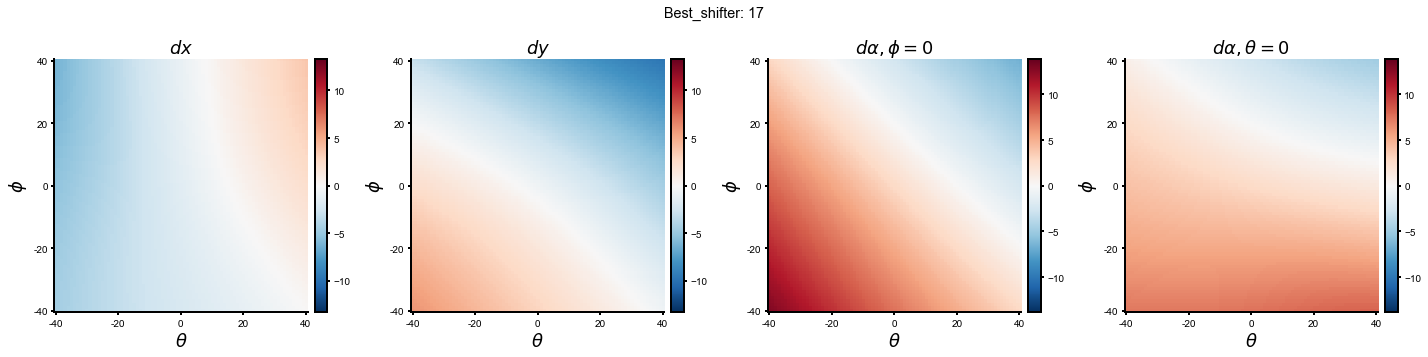

In [26]:
# l1.cpu()
FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)


fig, ax = plt.subplots(1,4,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(4):
    im1=ax[n].imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(ticklabels)
    ax[n].set_yticks(ticks)
    ax[n].set_yticklabels(ticklabels)
    ax[n].set_xlabel(r'$\theta$')
    ax[n].set_ylabel(r'$\phi$')
    ax[n].set_title(shift_titles[n])

plt.suptitle('Best_shifter: {}'.format(best_shifter))
plt.tight_layout()


array([0.93885552, 0.93515669, 0.94866254])

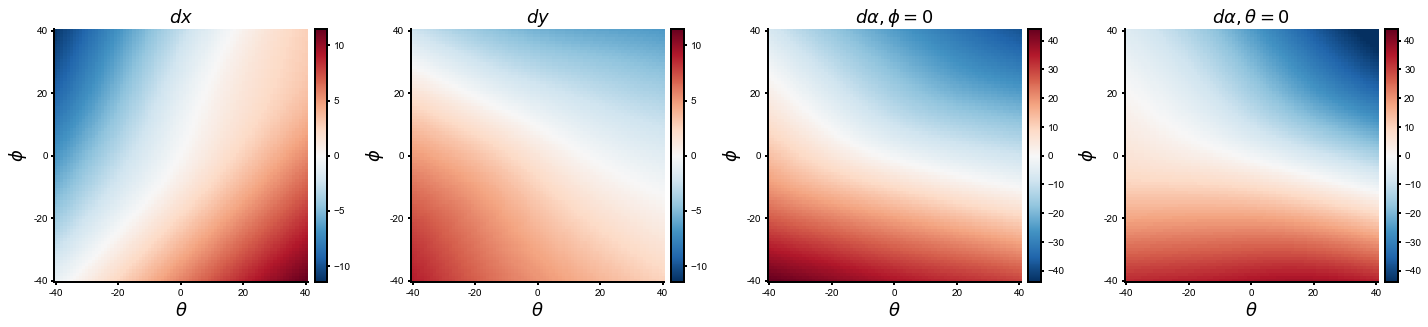

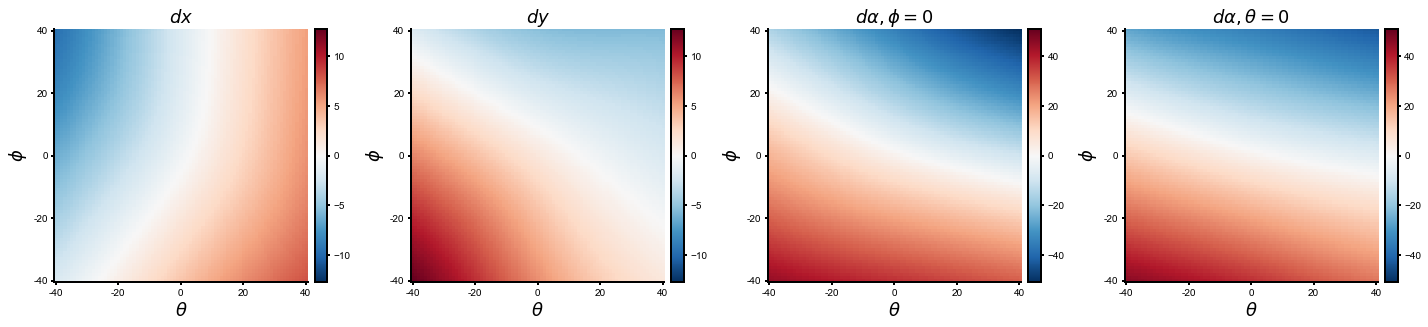

In [64]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
crange_list = np.stack((np.max(np.abs(shift_mat0[:2])),np.max(np.abs(shift_mat0[:2])), np.max(np.abs(shift_mat0[2])), np.max(np.abs(shift_mat0[2]))))
for n in range(4):
    im1=ax[n].imshow(shift_mat0[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(ticklabels)
    ax[n].set_yticks(ticks)
    ax[n].set_yticklabels(ticklabels)
    ax[n].set_xlabel(r'$\theta$')
    ax[n].set_ylabel(r'$\phi$')
    ax[n].set_title(shift_titles[n])
plt.tight_layout()

fig, ax = plt.subplots(1,4,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
crange_list = np.stack((np.max(np.abs(shift_mat1[:2])),np.max(np.abs(shift_mat1[:2])), np.max(np.abs(shift_mat1[2])), np.max(np.abs(shift_mat1[2]))))
for n in range(4):
    im1=ax[n].imshow(shift_mat1[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(ticklabels)
    ax[n].set_yticks(ticks)
    ax[n].set_yticklabels(ticklabels)
    ax[n].set_xlabel(r'$\theta$')
    ax[n].set_ylabel(r'$\phi$')
    ax[n].set_title(shift_titles[n])
plt.tight_layout()

np.array([r2_score(shift_mat0[n].flatten(),shift_mat1[n].flatten()) for n in range(shift_mat.shape[0])])


In [56]:
from sklearn.metrics import r2_score

[0.9388555175908182, 0.9351566868795393, 0.9486625372104209]

In [61]:
np.corrcoef(shift_mat0[0].flatten(),shift_mat1[0].flatten()),r2_score(shift_mat0[0].flatten(),shift_mat1[0].flatten())

(array([[1.        , 0.97428136],
        [0.97428136, 1.        ]]),
 0.9388555175908182)

# Single Comparison

In [8]:
da = 0
args['date_ani'] = dates_all[da]
args['free_move'] = True
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]


Done Loading Unaligned data
Tot_units: (128,)


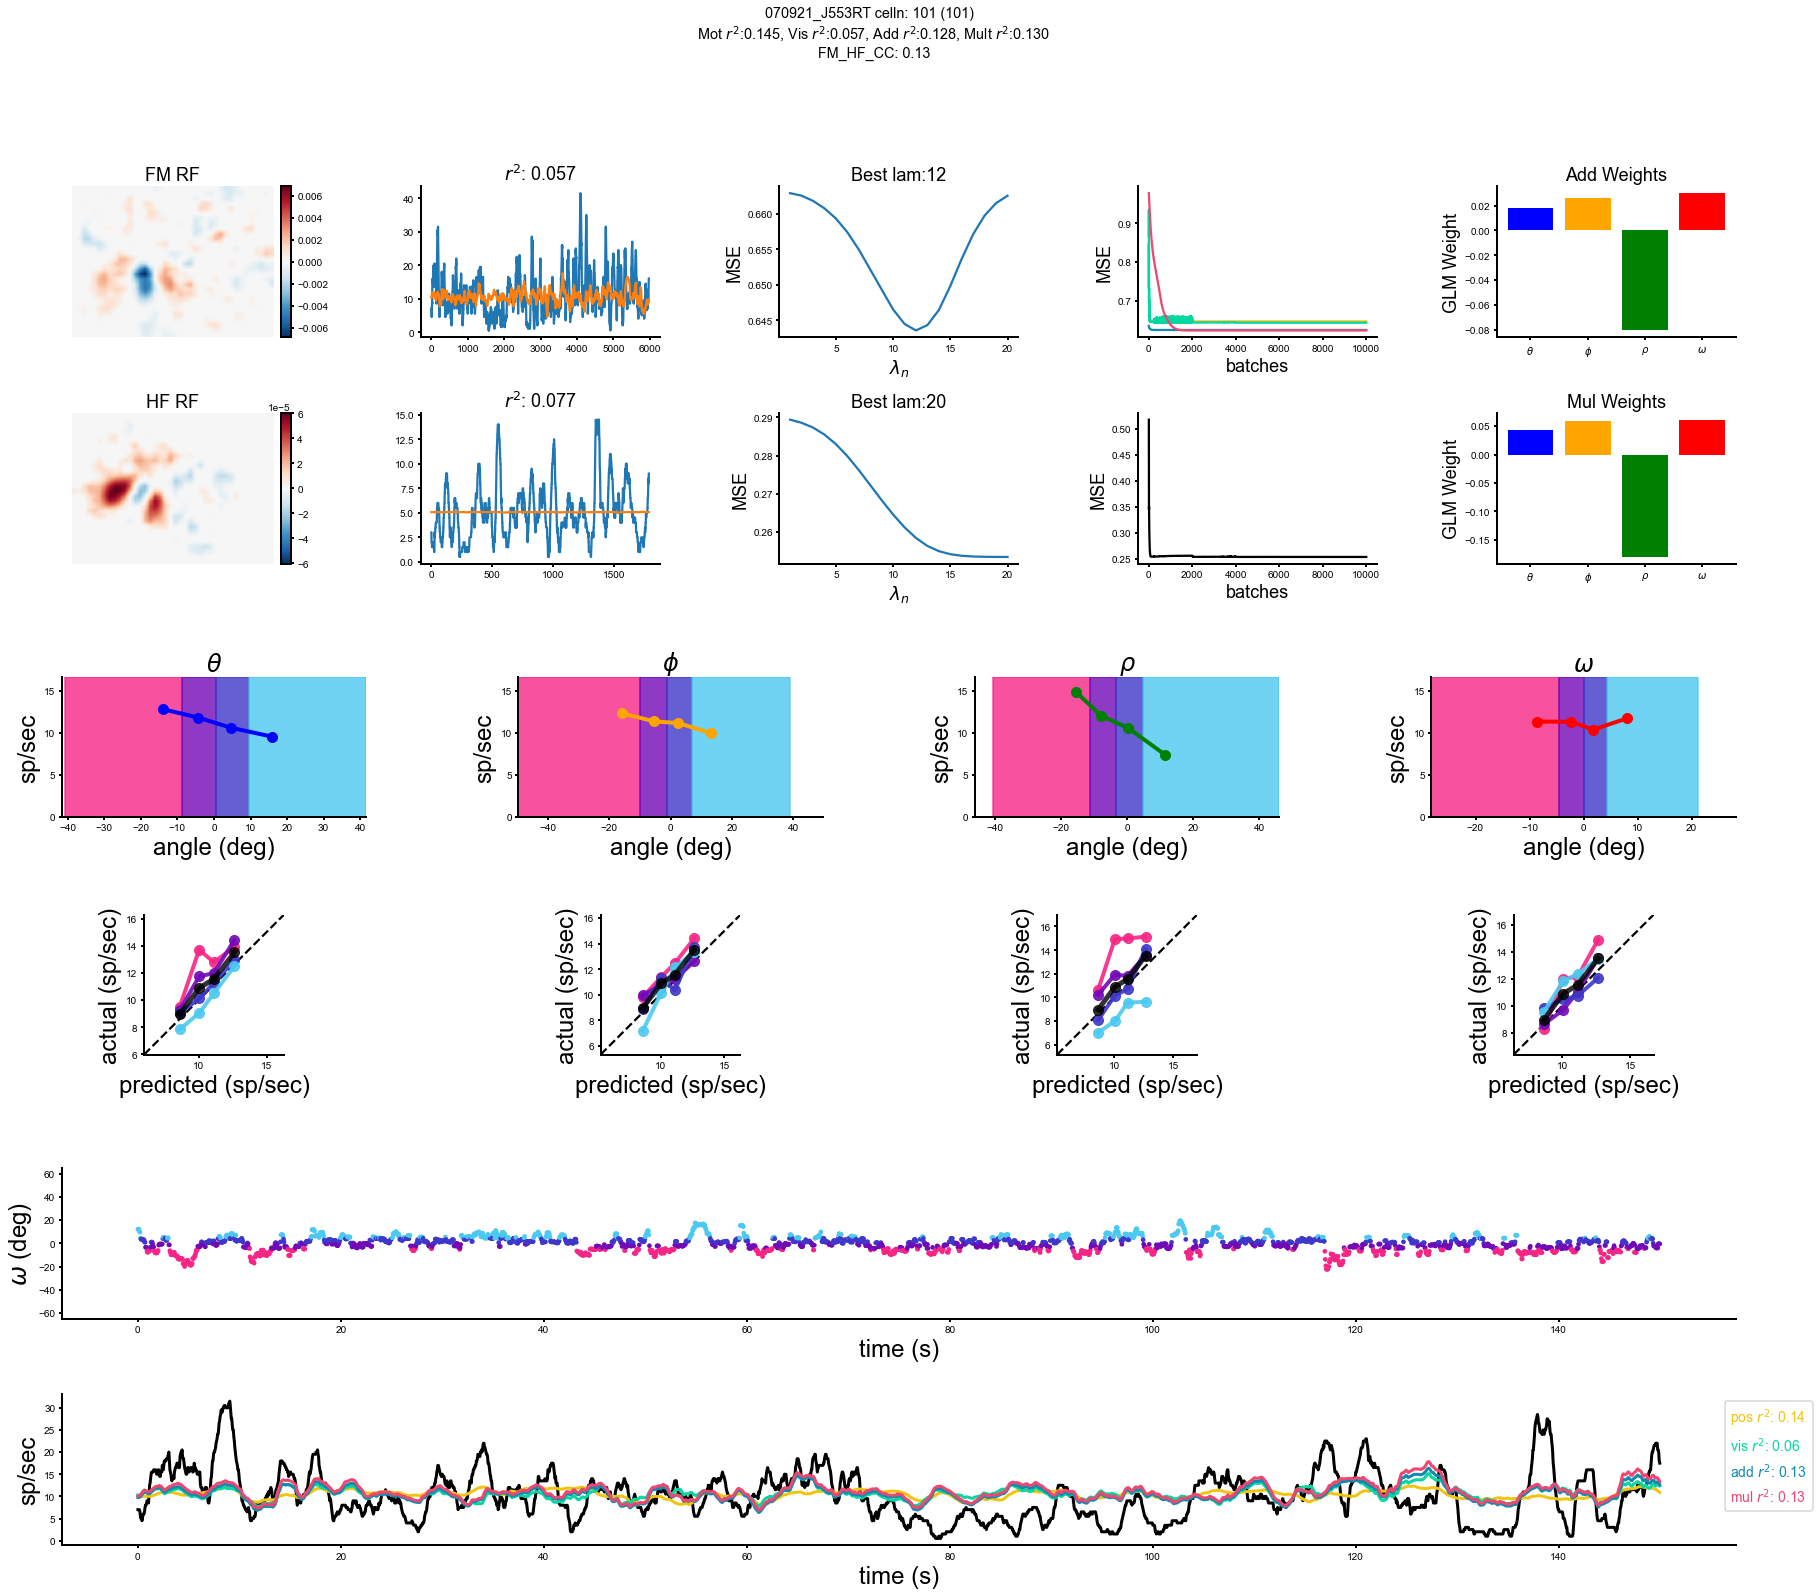

In [9]:
celln = 101
modN = 1
fontsize=24
anglim=65
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) 
fig = plt.figure(constrained_layout=False, figsize=(30,25))
gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

########## Plotting FM/HF RFs ##########
gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

ax = axs0a[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')
ax.set_title('FM RF')

ax = axs0a[1]
ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['vis_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['vis_r2_test'][celln]))

ax = axs0a[2]
ax.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])))

ax =axs0a[3]
for modN in range(len(mod_titles)-1):
    ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

########### Head Fixed plots ###########
ax = axs0b[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.set_title('HF RF')
ax.axis('off')

ax = axs0b[1]
ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['HF_r2_test'][celln]))

ax = axs0b[2]
ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

ax =axs0b[3]
ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

######### Position Weights ##########

w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
for modeln in range(len(titles)):
    axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
    axs0a[4].set_xticks(np.arange(0,len(titles)))
    axs0a[4].set_xticklabels(titles)
    axs0a[4].set_ylabel('GLM Weight')
    axs0a[4].set_title('Add Weights')

    axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
    axs0b[4].set_xticks(np.arange(0,len(titles)))
    axs0b[4].set_xticklabels(titles)
    axs0b[4].set_ylabel('GLM Weight')
    axs0b[4].set_title('Mul Weights')



########## Fig 4A ########## 
gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#
    for m in range(len(nranges)-1):
        axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
    axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
    axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
    axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
    axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

    
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts 
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].axis('square')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    # axs1b[0,modeln].axis('equal')
    axs1b[0,modeln].set(xlim=lims, ylim=lims)
    # axs1b[0,modeln].set_ylim(bottom=0)



########## Fig 4B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

cmap = mpl.colors.ListedColormap(q_clrs)
##### Plotting Position Scatter #####
t0=0
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-t0)) # 200 seconds in #6000
dt = int(150/params['model_dt']) # All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2[0,0]
metric = move_data[params['bin_length']:-params['bin_length'],3]
ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
ax.set_ylabel(r'$\omega$ (deg)',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylim([-anglim,anglim])

# celln = 18#106
# da = 0
# t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
# dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2b[0,0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
for modN in range(len(mod_titles)-1):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

Mot_r2 = All_data[date_ani2[da]]['pos_r2_test'][celln]
Vis_r2 = All_data[date_ani2[da]]['vis_r2_test'][celln]
Add_r2 = All_data[date_ani2[da]]['add_r2_test'][celln]
Mul_r2 = All_data[date_ani2[da]]['mul_r2_test'][celln]
FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_r2'][celln]
plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,celln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
plt.show()

In [21]:
pred_time.shape,metric[t:t+dt].shape

((3000,), (1,))

In [22]:
int(150/params['model_dt'])

3000

In [17]:
GLM_Data = ioh5.load(ModelList[1])
GLM_Data.keys()

dict_keys(['Cell_NN.0.bias', 'Cell_NN.0.weight', 'cc_test', 'loss_regcv', 'out_cv', 'pred_cv', 'r2_test', 'tloss_trace_all', 'vloss_trace_all'])

86

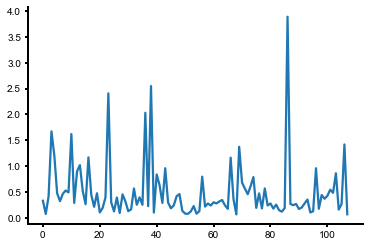

In [21]:
plt.plot(GLM_Data['tloss_trace_all'][:,-1])
np.argmax(GLM_Data['tloss_trace_all'][:,-1])

# Comparison of all Plots

In [15]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))


In [ ]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['Pos','Vis','Add','Mul','HF']
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all = [],[], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag'] = 5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(set(date_ani_dir.rglob(mod_name+'.h5')) - set(date_ani_dir.rglob('*VisNoShifter'+mod_name+'.h5')))))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)



Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:662: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [ ]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun == 4):
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)


In [16]:

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)


In [ ]:
save_pdf = True
anglim = 65
fontsize=24
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'PaperFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
pdf_name = paper_fig_dir/ ('MoViAdMuHF_AllCells_CellSummary.pdf')
totcelln = 0
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig = plt.figure(constrained_layout=False, figsize=(30,10))
    gs0 = gridspec.GridSpec(nrows=2, ncols=5, figure=fig,wspace=.8,hspace=.3)

    ########## Histograms of R2 ##########
    axs0a = np.array([fig.add_subplot(gs0[0, n]) for n in range(gs0.ncols)])
    axs0b = np.array([fig.add_subplot(gs0[1, n]) for n in range(gs0.ncols)])

    vals_Mot = np.hstack([All_data[date_ani2[da]]['pos_r2_test'] for da in range(len(dates_all))])
    vals_Vis = np.hstack([All_data[date_ani2[da]]['vis_r2_test'] for da in range(len(dates_all))])
    vals_Add = np.hstack([All_data[date_ani2[da]]['add_r2_test'] for da in range(len(dates_all))])
    vals_Mul = np.hstack([All_data[date_ani2[da]]['mul_r2_test'] for da in range(len(dates_all))])
    vals_HF  = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
    vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_r2']  for da in range(len(dates_all))])

    r2_all = np.stack((vals_Mot,vals_Vis,vals_Add,vals_Mul,vals_HF))
    hbins=.05
    for n in range(len(mod_titles)):
        ax = axs0a[n]
        count,edges = np.histogram(r2_all[n],bins=np.arange(0,1,hbins))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
        ax.set_xticks(np.arange(0,1.2,.2))
        ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
        ax.set_title(mod_titles[n])
        ax.set_xlabel(r'$r^2$')

    ax=axs0b[-1]
    count,edges = np.histogram(np.abs(vals_FMHF),bins=np.arange(0,1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
    ax.set_xticks(np.arange(0,1.2,.2))
    ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
    ax.set_title('FM_HF_CC')
    ax.set_xlabel('cc')
    ########## Scatter of all R2 ########## 

    tuning_idx = np.where(tuning_sig_all)[0]
    lims = (0, .65)
    crange=500
    ##### Vis vs Mot #####
    ax = axs0b[0]
    # im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[1],cmap='jet',s=20,vmin=-crange,vmax=crange)
    # ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    # ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    # ax.set_ylabel('Position: $r^2$',fontsize=fontsize)
    # ax.set_yticks(np.arange(0,lims[1],.2))
    # ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    # ax.set_ylim(0,lims[1])
    # ax.set_xlim(0,lims[1])
    # ax.set_xticks(np.arange(0,lims[1],.2))
    # ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    # ax.axis('equal')
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    ##### Vis vs Add/Mul #####
    cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
    vals_AM = np.max(np.stack((vals_Add,vals_Mul)),axis=0)
    AvM = vals_Add<vals_Mul
    ax = axs0b[1]
    scatter=ax.scatter(vals_Vis,vals_AM,30,c=AvM,cmap=cmap_mod)
    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    ax.set_ylabel('$r^2$',fontsize=fontsize)
    ax.set_yticks(np.arange(0,lims[1],.2))
    ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.set_ylim(0,lims[1])
    ax.set_xlim(0,lims[1])
    ax.set_xticks(np.arange(0,lims[1],.2))
    ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.axis('equal')
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),fontsize=14,markerscale=0, handlelength=0, handletextpad=0,loc="best")
    legend1.get_texts()[0].set_text('Add') 
    legend1.get_texts()[0].set_color(mod_clrs[2])
    legend1.get_texts()[1].set_text('Mul')
    legend1.get_texts()[1].set_color(mod_clrs[3])

    vloss_Mot = np.hstack([All_data[date_ani2[da]]['pos_vloss_trace'] for da in range(len(dates_all))])
    vloss_Vis = np.hstack([All_data[date_ani2[da]]['vis_vloss_trace'] for da in range(len(dates_all))])
    vloss_Add = np.hstack([All_data[date_ani2[da]]['add_vloss_trace'] for da in range(len(dates_all))])
    vloss_Mul = np.hstack([All_data[date_ani2[da]]['mul_vloss_trace'] for da in range(len(dates_all))])

    # ##### MSE #####
    # diff = vloss_Add-vloss_Mul
    # increase = 1-vloss_Vis
    # th = increase>-0

    # NMul = np.sum(diff[th]>0)
    # NAdd = np.sum(diff[th]<0)
    # ax=axs0b[2]
    # im=ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    # ax.axvline(x=0,c='k')
    # ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    # ax.set_xlabel('MSE: Add-Mul',fontsize=fontsize)
    # ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    # ax.set_ylim(-.05,.25)
    # ax.set_xlim(-.02,.02)
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    # ##### R2 Explained Variance #####
    # diff = vals_Mul-vals_Add
    # increase = 1-vloss_Vis
    # th = increase>-0

    # NMul = np.sum(diff[th]>0)
    # NAdd = np.sum(diff[th]<0)
    # ax=axs0b[3]
    # im = ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    # ax.axvline(x=0,c='k')
    # ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    # ax.set_xlabel('R2: Mul-Add',fontsize=fontsize)
    # ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    # ax.set_ylim(-.05,.25)
    # ax.set_xlim(-.075,.075)
    # cbar = add_colorbar(im)
    # cbar.set_ticks([-crange,0,crange])
    # cbar.set_ticklabels([-crange,0,crange])
    # cbar.ax.tick_params(labelsize=fontsize-10)
    # cbar.set_label(r'depth $(\mu m)$')

    plt.tight_layout()
    pdf.savefig()
    plt.close()
for da in tqdm(np.arange(len(date_ani2))):
    args['date_ani'] = dates_all[da]
    args['free_move'] = True
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    ncells=All_data[date_ani2[da]][mod_titles[0]+'_pred_smooth'].shape[-1]
    for celln in tqdm(np.arange(ncells)):
        predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
        nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
        pred_range = np.quantile(predcell,[.1,.9])
        test_nsp_range = np.quantile(nspcell,[.01,1])
        pred_rangelin = np.quantile(predcell,spike_percentiles)
        xbin_pts = np.quantile(predcell,spk_percentile2)
        stat_bins = len(pred_rangelin)
        fig = plt.figure(constrained_layout=False, figsize=(30,25))
        gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

        ########## Plotting FM/HF RFs ##########
        gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
        axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
        axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

        ax = axs0a[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')
        ax.set_title('FM RF')

        ax = axs0a[1]
        ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['vis_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_FM[celln]))

        ax = axs0a[2]
        ax.plot(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['vis_loss_regcv'][0,:,celln])))

        ax =axs0a[3]
        for modN in range(len(mod_titles)-1):
            ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ########### Head Fixed plots ###########
        ax = axs0b[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.set_title('HF RF')
        ax.axis('off')

        ax = axs0b[1]
        ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_HF[celln]))

        ax = axs0b[2]
        ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

        ax =axs0b[3]
        ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ######### Position Weights ##########

        w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
        w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
        for modeln in range(len(titles)):
            axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
            axs0a[4].set_xticks(np.arange(0,len(titles)))
            axs0a[4].set_xticklabels(titles)
            axs0a[4].set_ylabel('GLM Weight')
            axs0a[4].set_title('Add Weights')

            axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
            axs0b[4].set_xticks(np.arange(0,len(titles)))
            axs0b[4].set_xticklabels(titles)
            axs0b[4].set_ylabel('GLM Weight')
            axs0b[4].set_title('Mul Weights')



        ########## Fig 4A ########## 
        gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
        axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
        axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

        top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
        traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
        edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        for i,modeln in enumerate(range(len(titles))):
            metric = move_data[params['bin_length']:-params['bin_length'],modeln]
            nranges = np.quantile(metric,quartiles)
            stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
            edge_mids = np.quantile(metric,spk_percentile2)#
            for m in range(len(nranges)-1):
                axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
            axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
            axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
            xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
            axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
            axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
            axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
            axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

            try:
                stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts 
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]
                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                    axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
                    axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
                
                lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
                lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
                lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
                axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                # axs1b[0,modeln].axis('equal')
                axs1b[0,modeln].set(xlim=lims, ylim=lims)
                # axs1b[0,modeln].set_ylim(bottom=0)
            except:
                print(celln, 'Failed')


        ########## Fig 4B ########## 
        gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
        axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
        axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

        cmap = mpl.colors.ListedColormap(q_clrs)
        ##### Plotting Position Scatter #####
        t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
        dt = int(200/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2[0,0]
        metric = move_data[params['bin_length']:-params['bin_length'],3]
        ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
        ax.set_ylabel(r'$\rho$ (deg)',fontsize=fontsize)
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylim([-anglim,anglim])

        # celln = 18#106
        # da = 0
        # t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
        # dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
        ##### Plotting Firing Rate #####
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2b[0,0]
        zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
        ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
        for modN in range(len(mod_titles)-1):
            ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
                    label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
        ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylabel('sp/sec',fontsize=fontsize)

        Mot_r2 = All_data[date_ani2[da]]['pos_r2_test'][celln]
        Vis_r2 = All_data[date_ani2[da]]['vis_r2_test'][celln]
        Add_r2 = All_data[date_ani2[da]]['add_r2_test'][celln]
        Mul_r2 = All_data[date_ani2[da]]['mul_r2_test'][celln]
        FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_r2'][celln]
        plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,totcelln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
        totcelln = totcelln+1
        # fig.savefig(paper_fig_dir/'Fig4_draft_Cell52_101521.png', facecolor='white', transparent=True, bbox_inches='tight')
        # plt.tight_layout()
        if save_pdf:
            pdf.savefig()
            plt.close()
if save_pdf:
    pdf.close()


In [5]:
test_file = file_dict['save']+'/070921_J553RT_ModelData_dt025_rawWorldCam_2ds.h5'

In [6]:
data_test = ioh5.load(test_file)

# change in visual scene

In [2]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['train_shifter']   = False
args['Nepochs']         = 10000
args['free_move']       = True
args['NoL1']            = True
args['NoL2']            = True
args['reg_lap']         = True
args['do_shuffle']      = False
args['complex']         = False

params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

GLM_Shifter = ioh5.load(ModelList[0])
params['save_model_shift'] = params['save_model'].parent.parent / 'Shifter'

Done Loading Unaligned data
Tot_units: (128,)


In [3]:
params['save_dir_testing'] = Path('/home/seuss/Research/SensoryMotorPred_Data/data_testing/070921/J553RT/fm1')

In [108]:
def load_raw_data(file_dict, params, downsamp_vid=1, do_worldcam_correction=False, reprocess=False, medfiltbins=11):

    # open worldcam
    print('opening worldcam')
    world_data = xr.open_dataset(file_dict['world'])
    world_vid_raw = np.uint8(world_data['WORLD_video'])
    # resize worldcam
    sz = world_vid_raw.shape # raw video size
    # if size is larger than the target 60x80, resize by 0.5
    if sz[1]>160:
        downsamp = 0.5
        world_vid = np.zeros((sz[0],int(sz[1]*downsamp),int(sz[2]*downsamp)), dtype = 'uint8')
        for f in range(sz[0]):
            world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(int(sz[2]*downsamp),int(sz[1]*downsamp)))
    else:
        # if the worldcam has already been resized when the nc file was written in preprocessing, don't resize
        world_vid = world_vid_raw.copy()
    del world_vid_raw
    gc.collect()

    # world timestamps
    worldT = world_data.timestamps.copy()

    # load IMU data
    if file_dict['imu'] is not None:
        print('opening imu data')
        imu_data = xr.open_dataset(file_dict['imu'])
        accT = imu_data.IMU_data.sample # imu timestamps
        acc_chans = imu_data.IMU_data # imu dample data
        # raw gyro values
        gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
        gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
        gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
        # gyro values in degrees
        gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
        gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
        gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
        # pitch and roll in deg
        groll = medfilt(np.array(acc_chans.sel(channel='roll')),medfiltbins)
        gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),medfiltbins)

    else: 
        accT = []
        gz = []
        groll = []
        gpitch = []


    print('opening ephys data')
    # ephys data for this individual recording
    ephys_data = pd.read_json(file_dict['ephys'])
    # sort units by shank and site order
    ephys_data = ephys_data.sort_values(by='ch', axis=0, ascending=True)
    ephys_data = ephys_data.reset_index()
    ephys_data = ephys_data.drop('index', axis=1)
    # spike times
    ephys_data['spikeTraw'] = ephys_data['spikeT']
    print('getting good cells')
    # select good cells from phy2
    goodcells = ephys_data.loc[ephys_data['group']=='good']
    units = goodcells.index.values
    # get number of good units
    n_units = len(goodcells)

    print('opening eyecam data')
    # load eye data
    eye_data = xr.open_dataset(file_dict['eye'])
    eye_vid = np.uint8(eye_data['REYE_video'])
    eyeT = eye_data.timestamps.copy()

    # plot eye postion across recording
    eye_params = eye_data['REYE_ellipse_params']
    # define theta, phi and zero-center
    th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)
    phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)

    print('adjusting camera times to match ephys')
    # adjust eye/world/top times relative to ephys
    ephysT0 = ephys_data.iloc[0,12]
    eyeT = eye_data.timestamps  - ephysT0
    if eyeT[0]<-600:
        eyeT = eyeT + 8*60*60 # 8hr offset for some data
    worldT = world_data.timestamps - ephysT0
    if worldT[0]<-600:
        worldT = worldT + 8*60*60
    accTraw = imu_data.IMU_data.sample - ephysT0

    ##### Clear some memory #####
    del eye_data 
    gc.collect()
    print(world_vid.shape)


    # calculate eye veloctiy
    dEye = np.diff(th)
    accT_correction_file = params['save_dir']/'acct_correction.h5'
    if (accT_correction_file.exists()):
        accT_correction = ioh5.load(accT_correction_file)
        offset0    = accT_correction['offset0']
        drift_rate = accT_correction['drift_rate']
        accT = accTraw - (offset0 + accTraw*drift_rate)
    else:
        # check accelerometer / eye temporal alignment
        if (file_dict['imu'] is not None):
            print('checking accelerometer / eye temporal alignment')
            lag_range = np.arange(-0.2,0.2,0.002)
            cc = np.zeros(np.shape(lag_range))
            t1 = np.arange(5,len(dEye)/60-120,20).astype(int) # was np.arange(5,1600,20), changed for shorter videos
            t2 = t1 + 60
            offset = np.zeros(np.shape(t1))
            ccmax = np.zeros(np.shape(t1))
            acc_interp = interp1d(accTraw, (gz-3)*7.5)
            for tstart in tqdm(range(len(t1))):
                for l in range(len(lag_range)):
                    try:
                        c, lag= nanxcorr(-dEye[t1[tstart]*60 : t2[tstart]*60] , acc_interp(eyeT[t1[tstart]*60:t2[tstart]*60]+lag_range[l]),1)
                        cc[l] = c[1]
                    except: # occasional problem with operands that cannot be broadcast togther because of different shapes
                        cc[l] = np.nan
                offset[tstart] = lag_range[np.argmax(cc)]    
                ccmax[tstart] = np.max(cc)
            offset[ccmax<0.1] = np.nan
            del ccmax, dEye
            gc.collect()
            if np.isnan(offset).all():
                found_good_offset = False
            else:
                found_good_offset = True

        if file_dict['imu'] is not None and found_good_offset is True:
            print('fitting regression to timing drift')
            # fit regression to timing drift
            model = LinearRegression()
            dataT = np.array(eyeT[t1*60 + 30*60])
            model.fit(dataT[~np.isnan(offset)].reshape(-1,1),offset[~np.isnan(offset)]) 
            offset0 = model.intercept_
            drift_rate = model.coef_
            del dataT
            gc.collect()
        elif file_dict['speed'] is not None or found_good_offset is False:
            offset0 = 0.1
            drift_rate = -0.000114
        if file_dict['imu'] is not None:
            accT_correction = {'offset0': offset0, 'drift_rate': drift_rate}
            ioh5.save(accT_correction_file,accT_correction)
            accT = accTraw - (offset0 + accTraw*drift_rate)
            del accTraw
            gc.collect()


    print('correcting ephys spike times for offset and timing drift')
    for i in ephys_data.index:
        ephys_data.at[i,'spikeT'] = np.array(ephys_data.at[i,'spikeTraw']) - (offset0 + np.array(ephys_data.at[i,'spikeTraw']) *drift_rate)
    goodcells = ephys_data.loc[ephys_data['group']=='good']

    return eyeT,accT,worldT,th,phi,groll,gpitch,gz_deg,world_vid,ephys_data

eyeT,accT,worldT,th,phi,groll,gpitch,gz_deg,world_vid,ephys_data = load_raw_data(file_dict,params)

opening worldcam
opening imu data
opening ephys data
getting good cells
opening eyecam data


KeyboardInterrupt: 

In [42]:
Timestamps = {
'eyeT':   eyeT.data.copy(),
'accT':   accT.data.copy(),
'worldT': worldT.data.copy(),
}
ioh5.save(params['save_dir_testing']/'img_registration_correction_timestamps.h5',Timestamps)
pos_data = {
'th':       th.copy(),
'phi':      phi.copy(),
'groll':    groll.copy(),
'gpitch':   gpitch.copy(),
}

In [6]:
##### Add in interpolaters for getting same time basis.
interp_th = interp1d(Timestamps['eyeT'],pos_data['th'], bounds_error=False)
interp_phi = interp1d(Timestamps['eyeT'],pos_data['phi'], bounds_error=False)
interp_groll = interp1d(Timestamps['accT'],pos_data['groll'], bounds_error=False)
interp_gpitch = interp1d(Timestamps['accT'],pos_data['gpitch'], bounds_error=False)

model_pos = np.vstack((interp_th(Timestamps['worldT']),interp_phi(Timestamps['worldT']),interp_groll(Timestamps['worldT']),interp_gpitch(Timestamps['worldT']))).T


In [7]:
move_med_win = 11

FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
for n in np.arange(4):
    model_pos[:,n] = ((pd.DataFrame(model_pos[:,n]).interpolate(axis=0).to_numpy() - FM_move_avg[0,n])/FM_move_avg[1,n]).squeeze()

model_pos[:,2] = medfilt(model_pos[:,2],move_med_win)
model_pos[:,3] = medfilt(model_pos[:,3],move_med_win)

In [8]:
print('Loading and processing shifter')
params['model_type'] = 'Pytorch_VisShifter_NoL1'
##### Load single shifter network and shift videos #####
best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=50
shift_out=3
# save_model_fm = params['save_model_shift']
save_model_fm = params['save_model_shift'].parent.parent.parent / 'fm1' / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(params['model_type'],'UC',int(.05*1000), 1, MovModel, 2000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

ds = 4/params['downsamp_vid']
shift_out = shifter_nn(torch.from_numpy(model_pos[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
vid_tensor=torch.from_numpy(world_vid[:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()

Loading and processing shifter
11


/tmp/ipykernel_239303/3039277329.py:4: RuntimeWarning: Mean of empty slice
  best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))


In [63]:

start = time.time()
# get eye displacement for each worldcam frame
th_interp = interp1d(eyeT, th, bounds_error=False)
phi_interp = interp1d(eyeT, phi, bounds_error=False)
dth = np.diff(th_interp(worldT))
dphi = np.diff(phi_interp(worldT))

# calculate x-y shift for each worldcam frame  
number_of_iterations = 5000
termination_eps = 1e-4
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)
warp_mode = cv2.MOTION_TRANSLATION

# Parallel Testing
world_vid_r = ray.put(model_vid_sm_shift) # world_vid
warp_mode_r = ray.put(warp_mode)
criteria_r = ray.put(criteria)
dt = 1
max_frames = world_vid.shape[0]
result_ids = []
[result_ids.append(shift_vid_parallel.remote(i, world_vid_r, warp_mode_r, criteria_r, dt)) for i in range(0, max_frames, dt)]
results_p = ray.get(result_ids)
results_p = np.array(results_p).transpose(0,2,1).reshape(-1,3)

xshift = results_p[:,0]
yshift = results_p[:,1]
cc = results_p[:,2]


(shift_vid_parallel pid=201969) 
(shift_vid_parallel pid=201994) 
(shift_vid_parallel pid=201987) 
(shift_vid_parallel pid=201974) 
(shift_vid_parallel pid=201993) 
(shift_vid_parallel pid=201972) 
(shift_vid_parallel pid=201986) 
(shift_vid_parallel pid=201986) 
(shift_vid_parallel pid=201969) 
(shift_vid_parallel pid=201973) 
(shift_vid_parallel pid=201966) 
(shift_vid_parallel pid=201993) 
(shift_vid_parallel pid=201964) 


In [64]:
np.sum(np.isnan(cc))

47

In [65]:

xmodel = LinearRegression()
ymodel = LinearRegression()

# eye data as predictors
eyeData = np.zeros((max_frames-1,2))
eyeData[:,0] = dth[0:max_frames-1]
eyeData[:,1] = dphi[0:max_frames-1]
# shift in x and y as outputs
xshiftdata = xshift[0:max_frames-1]
yshiftdata = yshift[0:max_frames-1]
# only use good data
# not nans, good correlation between frames, small eye movements (no sacccades, only compensatory movements)
usedata = ~np.isnan(eyeData[:,0]) & ~np.isnan(eyeData[:,1]) & (cc[:-1]>0.95)  & (np.abs(eyeData[:,0])<2) & (np.abs(eyeData[:,1])<2) & (np.abs(xshiftdata)<5) & (np.abs(yshiftdata)<5)

# fit xshift
xmodel.fit(eyeData[usedata,:],xshiftdata[usedata])
xmap = xmodel.coef_
xrscore = xmodel.score(eyeData[usedata,:],xshiftdata[usedata])
# fit yshift
ymodel.fit(eyeData[usedata,:],yshiftdata[usedata])
ymap = ymodel.coef_
yrscore = ymodel.score(eyeData[usedata,:],yshiftdata[usedata])
world_shifts = {'xmap': xmap,
                'ymap': ymap,
                'xrscore': xrscore,
                'yrscore': yrscore,
                }
warp_mat_duration = time.time() - start
print("warp mat duration =", warp_mat_duration)
del results_p, warp_mode_r, criteria_r, result_ids
gc.collect()


warp mat duration = 1639.136934041977


0

In [68]:
img_reg = {
            'xshift': xshift,
            'yshift': yshift,
            'cc':     cc, 
            'worldT': worldT,
            }

img_reg.update(world_shifts)
ioh5.save(params['save_dir_testing']/'img_registration_correction_shifter.h5',img_reg)

In [ ]:

start = time.time()
print('estimating eye-world calibration')
xcorrection_r = ray.put(xmap.copy())
ycorrection_r = ray.put(ymap.copy())
print('shifting worldcam for eyes')

thInterp_r = ray.put(th_interp(worldT))
phiInterp_r = ray.put(phi_interp(worldT))

dt = 1000
result_ids2 = []
[result_ids2.append(shift_world_pt2.remote(f, dt, world_vid_r, thInterp_r, phiInterp_r, ycorrection_r, xcorrection_r)) for f in range(0, world_vid.shape[0], dt)] # 
results = ray.get(result_ids2)
world_vid = np.concatenate(results,axis=0).astype(np.uint8)
print('saving worldcam video corrected for eye movements')
shift_world_duration = time.time() - start
print("shift world duration =", shift_world_duration)
print('Total Duration:', warp_mat_duration + shift_world_duration)
warp_mat_duration = time.time() - start
print("warp mat duration =", warp_mat_duration)
del results_p, warp_mode_r, criteria_r, result_ids
gc.collect()


In [4]:
img_reg1 = ioh5.load(params['save_dir_testing']/'img_registration_correction.h5')
img_reg_shift = ioh5.load(params['save_dir_testing']/'img_registration_correction_shifter.h5')
Timestamps = ioh5.load(params['save_dir_testing']/'img_registration_correction_timestamps.h5')


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


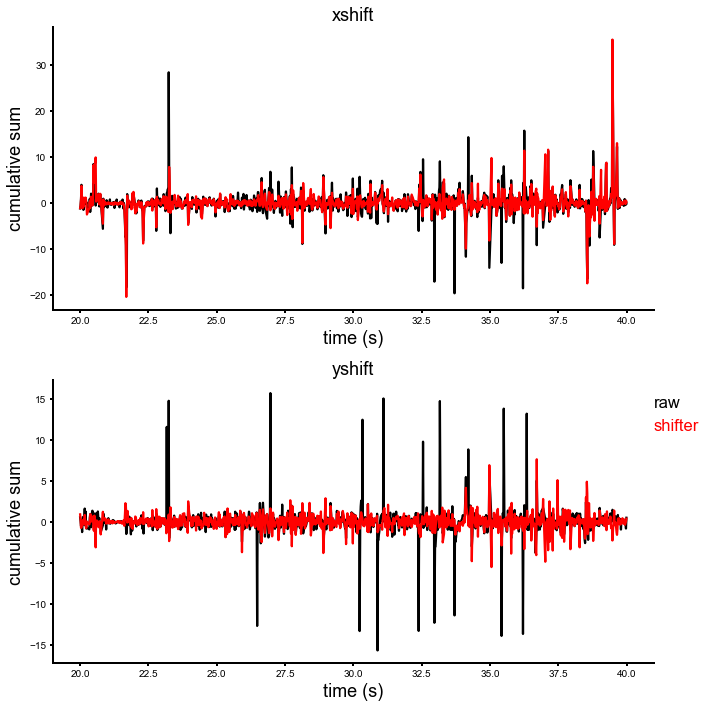

In [5]:
startT = 20 #47
endT = 40 # 240
moveTmin = np.nanargmin(np.abs(Timestamps['worldT']-startT))
moveTmax = np.nanargmin(np.abs(Timestamps['worldT']-endT))

# moveTmin = 2000
# moveTmax = 3000 #len(Timestamps['worldT'])
t_range = Timestamps['worldT'][moveTmin:moveTmax]

fig,axs = plt.subplots(2,1,figsize=(10,10))
ax = axs[0]
ax.plot(t_range,(img_reg1['xshift'][moveTmin:moveTmax]),c='k', label='raw')
ax.plot(t_range,(img_reg_shift['xshift'][moveTmin:moveTmax]),c='r', label='shifter')
ax.set_ylabel('cumulative sum')
ax.set_xlabel('time (s)')
ax.set_title('xshift')

ax = axs[1]
ax.plot(t_range,(img_reg1['yshift'][moveTmin:moveTmax]),c='k',label='raw')
ax.plot(t_range,(img_reg_shift['yshift'][moveTmin:moveTmax]),c='r',label='shifter')
ax.set_ylabel('cumulative sum')
ax.set_xlabel('time (s)')
ax.set_title('yshift')
ax.legend(labelcolor='linecolor', frameon=False, handlelength=0, handletextpad=0, bbox_to_anchor=(.6, .5, 0.5, 0.5))

plt.tight_layout()
# fig.savefig(paper_fig_dir/'change_in_vis.png', facecolor='white', transparent=True, bbox_inches='tight')


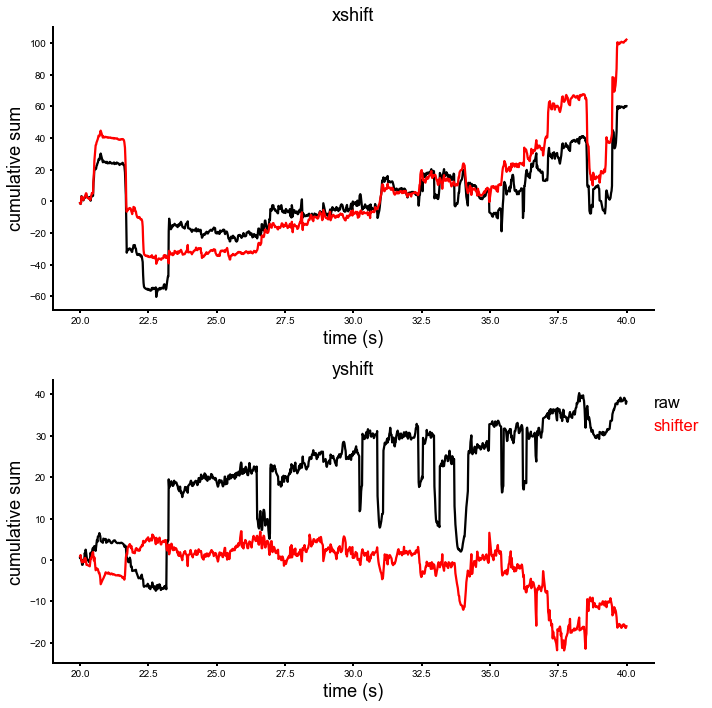

In [6]:
startT = 20 #47
endT = 40 # 240
moveTmin = np.nanargmin(np.abs(Timestamps['worldT']-startT))
moveTmax = np.nanargmin(np.abs(Timestamps['worldT']-endT))

# moveTmin = 2000
# moveTmax = 3000 #len(Timestamps['worldT'])
t_range = Timestamps['worldT'][moveTmin:moveTmax]

fig,axs = plt.subplots(2,1,figsize=(10,10))
ax = axs[0]
ax.plot(t_range,np.nancumsum(img_reg1['xshift'][moveTmin:moveTmax]),c='k', label='raw')
ax.plot(t_range,np.nancumsum(img_reg_shift['xshift'][moveTmin:moveTmax]),c='r', label='shifter')
ax.set_ylabel('cumulative sum')
ax.set_xlabel('time (s)')
ax.set_title('xshift')

ax = axs[1]
ax.plot(t_range,np.nancumsum(img_reg1['yshift'][moveTmin:moveTmax]),c='k',label='raw')
ax.plot(t_range,np.nancumsum(img_reg_shift['yshift'][moveTmin:moveTmax]),c='r',label='shifter')
ax.set_ylabel('cumulative sum')
ax.set_xlabel('time (s)')
ax.set_title('yshift')
ax.legend(labelcolor='linecolor', frameon=False, handlelength=0, handletextpad=0, bbox_to_anchor=(.6, .5, 0.5, 0.5))

plt.tight_layout()
# fig.savefig(paper_fig_dir/'change_in_vis.png', facecolor='white', transparent=True, bbox_inches='tight')


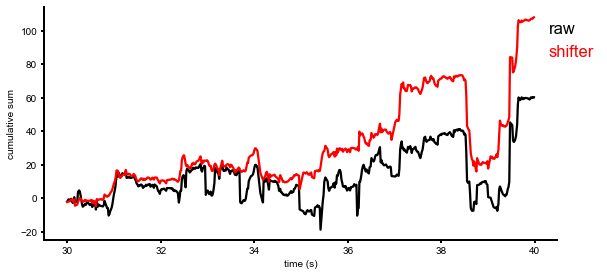

In [21]:
startT = 30 #47
endT = 40 # 240
moveTmin = np.nanargmin(np.abs(Timestamps['worldT']-startT))
moveTmax = np.nanargmin(np.abs(Timestamps['worldT']-endT))

# moveTmin = 2000
# moveTmax = 3000 #len(Timestamps['worldT'])
t_range = Timestamps['worldT'][moveTmin:moveTmax]

fig,axs = plt.subplots(1,1,figsize=(8,4))
ax = axs
ax.plot(t_range,np.nancumsum(np.abs(img_reg1['xshift'][moveTmin:moveTmax])),c='k', label='raw') #+img_reg1['yshift'][moveTmin:moveTmax]
ax.plot(t_range,np.nancumsum(np.abs(img_reg_shift['xshift'][moveTmin:moveTmax])),c='r', label='shifter') #+img_reg_shift['yshift'][moveTmin:moveTmax]
ax.set_ylabel('cumulative sum',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
# ax.set_title('xshift')

ax.legend(labelcolor='linecolor', frameon=False, handlelength=0, handletextpad=0, bbox_to_anchor=(.6, .5, 0.5, 0.5))
plt.tight_layout()

fig.savefig(paper_fig_dir/('dela_vis_scene.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)



# Darkness Data

In [27]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
args['fm_dark'] = False
if args['free_move']:
    stim_type = 'fm1'
elif args['fm_dark']:
    stim_type = 'fm1_dark'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['100821/J559TT', '101621/J559NC', '102721/J558NC', '110421/J558LT','110521/J569LT']
args['data_dir'] = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
args['date_ani'] = dates_all[0]
args['train_shifter']=True
args['NoL1'] = False
args['NoL2'] = False
args['complex'] = False
args['reg_lap'] = False
args['do_shuffle']=False
args['Nepochs'] = 10000


params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, comples: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))

Done Loading Unaligned data
Tot_units: (26,)
Model: 1, LinMix: False, move_features: None, Ncells: 7, train_shifter: True, NoL1: True, NoL2: False, reg_lap: False, comples: False


In [26]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all =  ['100821/J559TT', '101621/J559NC', '102721/J558NC', '110421/J558LT','110521/J569LT']
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    tuning_sig1,tuning_sig2a,NCells1,bad_cells1,test_nsp1,model_move1= [], [], [], [], [], [],
    for fm_dark in [False,True]:
        args['date_ani']    = date_ani
        args['data_dir'] = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
        args['free_move']   = True
        args['fm_dark']     = fm_dark
        if args['free_move']:
            stim_type       = 'fm1'
        elif args['fm_dark']:
            stim_type       = 'fm1_dark'
        else:
            stim_type       = 'hf1_wn'
        args['NoL1']        = False
        args['NoL2']        = False
        args['reg_lap']     = False
        args['complex']     = False
        args['do_shuffle']  = False
        args['Nepochs']     = 10000
        params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
        params['nt_glm_lag']=5
        date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
        params = get_modeltype(params)
        model_type = '_'.join(params['model_type'].split('_')[2:])
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
        # ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('RevisionSims' in path.as_posix()) &('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))
        # ModelList_all.append(ModelList)
        bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
        data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
        bad_cells1.append(bad_cells)
        # model_move1.append(model_move)
        tuning_sig1.append(tuning_sig)
        tuning_sig2a.append(tuning_sig2)
    bad_cells_all.append(np.stack(bad_cells1))
    # model_move_FM.append(np.stack(model_move1))
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(np.stack(tuning_sig1))
    tuning_sig_all2.append(np.stack(tuning_sig2a))
    NCells_all.append(len(tuning_sig2a))

# ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.concatenate(tuning_sig_all,axis=1)
# model_move_FM = np.concatenate(model_move_FM,axis=0)
# model_move_HF = np.concatenate(model_move_HF,axis=0)

ModelList_all

Done Loading Unaligned data
Tot_units: (26,)
Done Loading Unaligned data
Tot_units: (26,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (58,)
Done Loading Unaligned data
Tot_units: (58,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (73,)
Done Loading Unaligned data
Tot_units: (73,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (38,)
Done Loading Unaligned data
Tot_units: (38,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Tot_units: (46,)
Done Loading Unaligned data
Tot_units: (46,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:709: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


[]

/tmp/ipykernel_989650/1885984889.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


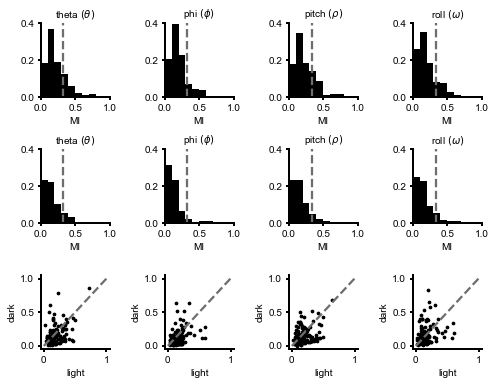

In [105]:
##### Modulation Index Histograms #####
dwidth = .1
# fig,axs = plt.subplots(2,len(titles),figsize=(8,4))
fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(nrows=1, ncols=5, figure=fig,wspace=.3,hspace=.8)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=4, subplot_spec=gs0[0,:-1],wspace=.8,hspace=.7)
# gs00 = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=4, subplot_spec=gs0[0,:-1],wspace=.8,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(3) for m in range(4) ]).reshape(3,4)
for dk in [0,1]:
    for modeln in np.arange(0,len(titles)):
        ax = axs1[dk,modeln]
        count,edges = np.histogram(tuning_sig_all[dk,:,modeln], bins=np.arange(0,1.1,dwidth))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(tuning_sig_all[dk,:,modeln]),color='k',width=dwidth,alpha=1)
        ax.axvline(x=.33,ls='--',color='#6D6E71')
        ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
        ax.set_xlabel('MI', fontsize=fontsize)
        # ax.set_ylabel('fraction of units', fontsize=fontsize)
        ax.set_xlim(0,1)
        ax.set_yticks(np.round(np.arange(0,.6,.2),decimals=1))
        ax.set_yticklabels(np.round(np.arange(0,.6,.2),decimals=1))
        ax.set_ylim(0,.4)
    axs[dk,0].set_ylabel('fraction of units', fontsize=fontsize)

for dk in [2]:
    for modeln in np.arange(0,len(titles)):
        ax = axs1[dk,modeln]
        ax.scatter(tuning_sig_all[0,:,modeln],tuning_sig_all[1,:,modeln],s=5,c='k')
        ax.plot(np.linspace(0,1,10),np.linspace(0,1,10),ls='--',color='#6D6E71')
        ax.set_xlabel('light',fontsize=fontsize)
        ax.set_ylabel('dark',fontsize=fontsize)
    


plt.tight_layout()
fig.savefig(paper_fig_dir/('DarkTuning.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)


In [36]:
da = 0
args['free_move'] = True
args['fm_dark'] = False
if args['free_move']:
    stim_type = 'fm1'
elif args['fm_dark']:
    stim_type = 'fm1_dark'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
args['do_shuffle']=False
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

Done Loading Unaligned data
Tot_units: (26,)


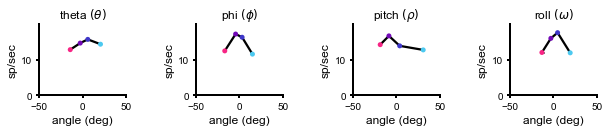

In [37]:
titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
celln = 5#106
modN = 0
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs = np.array([fig.add_subplot(gs00[0,m]) for m in range(4)])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
# traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
# traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
# edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

for modeln in range(len(titles)):
    ax = axs[modeln]
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
    stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

    edge_mids = np.quantile(metric,spk_percentile2)#
    # ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
    ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
    ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
    ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
    ax.set_xlim(-xlim_range,xlim_range)
    # ax.set_ylim(0,15)
    ax.set_xlabel('angle (deg)',fontsize=fontsize)
    ax.set_ylabel('sp/sec',fontsize=fontsize)
    ax.set_title(titles[modeln],fontsize=fontsize)

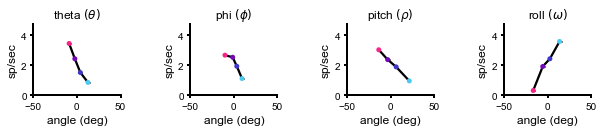

In [35]:
titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
celln = 5#106
modN = 0
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs = np.array([fig.add_subplot(gs00[0,m]) for m in range(4)])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
# traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
# traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
# edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

for modeln in range(len(titles)):
    ax = axs[modeln]
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
    stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

    edge_mids = np.quantile(metric,spk_percentile2)#
    # ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
    ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
    ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
    ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
    ax.set_xlim(-xlim_range,xlim_range)
    # ax.set_ylim(0,15)
    ax.set_xlabel('angle (deg)',fontsize=fontsize)
    ax.set_ylabel('sp/sec',fontsize=fontsize)
    ax.set_title(titles[modeln],fontsize=fontsize)

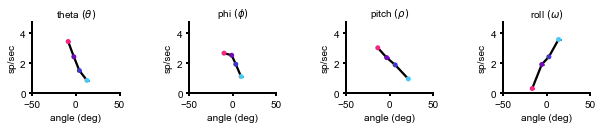

In [ ]:
titles = [r'theta $(\theta)$',r'phi $(\phi)$',r'pitch $(\rho)$',r'roll $(\omega)$']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
celln = 5#106
modN = 0
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,wspace=.3,hspace=.8)

########## Fig 4A ########## 
##### Example Tuning Curve #####
gs00 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0,:],wspace=.8,hspace=.7)
# axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
axs = np.array([fig.add_subplot(gs00[0,m]) for m in range(4)])

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
# traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
# traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
# edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

for modeln in range(len(titles)):
    ax = axs[modeln]
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    stat_range_std, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='std',bins=nranges)
    stat_range_count, _, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='count',bins=nranges)

    edge_mids = np.quantile(metric,spk_percentile2)#
    # ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0,markeredgewidth=0)
    ax.errorbar(edge_mids,stat_range/params['model_dt'],yerr=stat_range_std/np.sqrt(stat_range_count), elinewidth=5,c='k',zorder=0,markeredgewidth=0)
    ax.scatter(edge_mids,stat_range/params['model_dt'],s=25, c=q_clrs,zorder=1,edgecolors='none')
    ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = 50 #np.max(np.abs([nranges[0],nranges[-1]]))
    ax.set_xlim(-xlim_range,xlim_range)
    # ax.set_ylim(0,15)
    ax.set_xlabel('angle (deg)',fontsize=fontsize)
    ax.set_ylabel('sp/sec',fontsize=fontsize)
    ax.set_title(titles[modeln],fontsize=fontsize)

# Shifter GLM to STA comparison

In [114]:
args = arg_parser(jupyter=True)
MovModel = 3
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
args['train_shifter']=True
args['NoL1'] = True
args['NoL2'] = True
args['reg_lap'] = True
args['complex'] = False
args['do_shuffle']=False
args['Nepochs'] = 10000


params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, comples: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))

GLM_Data = ioh5.load(ModelList[1])

Done Loading Unaligned data
Tot_units: (128,)
Model: 3, LinMix: False, move_features: 4, Ncells: 108, train_shifter: True, NoL1: True, NoL2: True, reg_lap: True, comples: False


In [115]:
xtr = xtr.reshape(xtr.shape[0],-1)
xte = xte.reshape(xte.shape[0],-1)

In [116]:
GLM_RF = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])

xtr = xtr.cpu().detach().numpy()
xtr = np.append(xtr,np.ones((xtr.shape[0],1)), axis=1) # append column of ones
ytr = ytr.cpu().detach().numpy()
xte = xte.cpu().detach().numpy()
xte = np.append(xte,np.ones((xte.shape[0],1)), axis=1) # append column of ones
yte = yte.cpu().detach().numpy()

In [117]:

import scipy.sparse as sparse
import scipy.linalg as linalg


Imat = np.eye(params['nk'])
consecutive = np.ones((params['nk'],1))
consecutive[params['nks'][1]-1::params['nks'][1]] = 0
diff = np.zeros((1,2)); diff[0,0] = -1; diff[0,1]= 1
Dxx = sparse.diags((consecutive @ diff).T, np.array([0, 1]), (params['nk']-1,params['nk']))
Dxy = sparse.diags((np.ones((params['nk'],1))@ diff).T, np.array([0, params['nks'][1]]), (params['nk'] - params['nks'][1], params['nk']))
Dx = Dxx.T @ Dxx + Dxy.T @ Dxy
D  = linalg.block_diag(Dx.toarray(),np.zeros((1,1)))      
Imat = linalg.block_diag(Imat,np.zeros((1,1)))
Cinv = D + Imat



In [118]:
xxtr = xtr.T@xtr
xytr = xtr.T@ytr


In [120]:
lambdas = 1024 * (2**np.arange(0,16))
nlam = len(lambdas)
w_ridge = np.zeros((nlam,params['nk']+1,ytr.shape[1]))
sta_all = np.zeros((ytr.shape[1], params['nks'][0], params['nks'][1] ))

cc_all = np.zeros((ytr.shape[1]))
msetrain = np.zeros((nlam,ytr.shape[1]))
msetest = np.zeros((nlam,ytr.shape[1]))
yte_pred_all = np.zeros((nlam,xte.shape[0],ytr.shape[1]))
for l in tqdm(range(len(lambdas))):  # loop over regularization strength
    sta2 = np.linalg.inv(xxtr + lambdas[l]*Cinv)@xytr
    w_ridge[l] =sta2
    msetrain[l] = np.mean((ytr - xtr@sta2)**2,axis=0)
    yte_pred = xte@sta2
    msetest[l] = np.mean((yte - yte_pred)**2,axis=0)
    yte_pred_all[l] = yte_pred

  0%|          | 0/16 [00:00<?, ?it/s]

In [125]:
yte_pred.shape

(6694, 108)

In [ ]:
best_lambda = np.nanargmin(np.mean(msetest,axis=1))
# ridge_rf = w_ridge[mlam,:,cellnum]
ridge_rf = w_ridge[best_lambda,:-1]
sta_im = ridge_rf.T.reshape((ytr.shape[1],params['nt_glm_lag'],)+params['nks'])
yte_pred = yte_pred_all[best_lambda]

0.16918575710566583

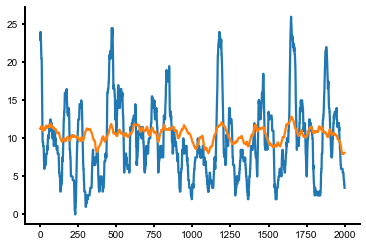

In [130]:
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yte)[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yte_pred)[params['bin_length']:-params['bin_length']]
cc_all = np.array([(np.corrcoef(yte[:,celln],yte_pred[:,celln])[0, 1]) for celln in range(yte.shape[1])])

t = 0
dt = 2000
celln = 101# np.nanargmax(GLM_Data['cc_test'])
plt.plot(sp_smooth[t:t+dt,celln])
plt.plot(pred_smooth[t:t+dt,celln])
cc_all[celln]


In [44]:
# sta = (xtr.T @ ytr)/np.sum(ytr,0,keepdims=True)
sta_im = sta2.T.reshape((ytr.shape[1],params['nt_glm_lag'],)+params['nks'])


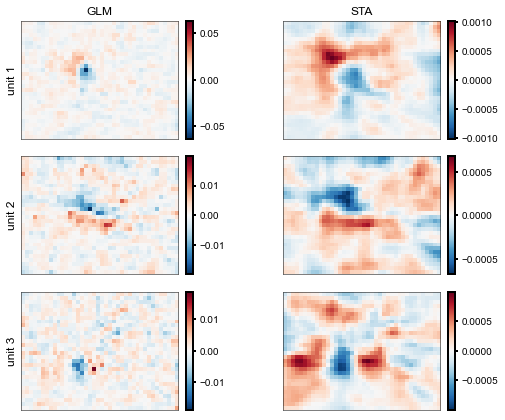

In [132]:
fontsize=12
lag_ls = ['GLM','STA'] # ['Normal','Square']
lag_list = [0,0] #params['lag_list']
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [22,42,101] #np.arange(20) # np.arange(All_data[date_ani2[da]]['vis_rf_all'].shape[0]) #

fig1,axs = plt.subplots(len(cells),len(lag_list),figsize=(4*len(lag_list),2*len(cells)))
axs = axs.reshape(len(cells),len(lag_list))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(GLM_RF[cell]))
    for m,lag in enumerate(lag_list):
        ax = axs[n,m]
        if m == 0:
            crange = np.max(np.abs(GLM_RF[cell]))
            im = ax.imshow(GLM_RF[cell,2],'RdBu_r',vmin=-crange,vmax=crange)
        else:
            crange = np.max(np.abs(sta_im[cell]))
            im = ax.imshow(sta_im[cell,2],'RdBu_r',vmin=-crange,vmax=crange)
        add_colorbar(im)
        axs[0,m].set_title('{}'.format(lag_ls[m]),fontsize=fontsize)
    axs[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
# fig1.savefig(paper_fig_dir/('GLM_STA_comparison.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)
